# Idea

Here I use a pipeline I created for the Prophet model to load and setup the data, predictors and holidays to train a model for each store and each family of products. I use the last 15 days of data for validation in each case and, after the models are trained, I make a small error analysis to understand where the most problematic error are.

In [2]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil, DATA_FOLDER
from storeSalesUtils.plotting import plot_joint_plot, plot_autocorrelations
from storeSalesUtils.prophetPipeline import (prophetPipeline, parse_holidays, parse_oil_prophet,
                                      visualize_forecasts, RMSLE, grangers_causation_matrix)

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prophet model all stores

In [4]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()
oil_prophet = parse_oil_prophet(oil)

test = load_test()

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', maxDate, minDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train.head()

Using data within the dates:  2017-08-15 00:00:00 2015-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,split
1700028,1700028,2015-08-15,1,AUTOMOTIVE,3.0,0,train
1700029,1700029,2015-08-15,1,BABY CARE,0.0,0,train
1700030,1700030,2015-08-15,1,BEAUTY,0.0,0,train
1700031,1700031,2015-08-15,1,BEVERAGES,2845.0,5,train
1700032,1700032,2015-08-15,1,BOOKS,0.0,0,train


In [4]:
prediction_df = []
val_errors = []

count = 0

tqdm.pandas()
for idx, storeFamily_daily in tqdm(train.groupby(['store_nbr', 'family'])):
    store_nbr, family = idx
    
    print(f'Prophet training for Store {store_nbr}, {family}')
    
    # storeFamily_daily = pd.merge(storeFamily_daily, stores, on='store_nbr')
    city = stores[stores.store_nbr==store_nbr].city.values[0]
    state = stores[stores.store_nbr==store_nbr].state.values[0]
    
    relevant_holidays = parse_holidays(holidays, city, state)
    
    model_pipeline = prophetPipeline(storeFamily_daily, oil_prophet, relevant_holidays, filter=True)
    
    storeFamily_daily_test = test[(test.store_nbr==store_nbr) & (test.family==family)]
    
    test_forecast = model_pipeline.prophet_predictTest(storeFamily_daily_test)
    test_forecast = test_forecast[['ds', 'yhat']].rename(mapper={'ds':'date', 'yhat':'sales'}, axis=1)
    test_forecast = pd.merge(test_forecast, storeFamily_daily_test, on='date')
    
    prediction_df.append(test_forecast)
    
    val_errors.append([store_nbr, family, model_pipeline.RMSLE_validation])
    
prediction_df = pd.concat(prediction_df)
print(prediction_df.shape)
prediction_df.head()

  0%|          | 0/1782 [00:00<?, ?it/s]

Prophet training for Store 1, AUTOMOTIVE


22:25:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:25:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, BABY CARE
Prophet training for Store 1, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:25:20 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


22:25:24 - cmdstanpy - INFO - Chain [1] start processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, BREAD/BAKERY


22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, CELEBRATION


22:25:28 - cmdstanpy - INFO - Chain [1] start processing
22:25:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, CLEANING


22:25:30 - cmdstanpy - INFO - Chain [1] start processing
22:25:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, DAIRY


22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, DELI


22:25:34 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, EGGS


22:25:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:25:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, FROZEN FOODS


22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, GROCERY I


22:25:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


22:25:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, GROCERY II


22:25:41 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:25:43 - cmdstanpy - INFO - Chain [1] start processing
22:25:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, HOME AND KITCHEN I


22:25:45 - cmdstanpy - INFO - Chain [1] start processing
22:25:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, HOME AND KITCHEN II


22:25:47 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, HOME APPLIANCES


22:25:49 - cmdstanpy - INFO - Chain [1] start processing
22:25:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, HOME CARE


22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, LADIESWEAR


22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, LAWN AND GARDEN


22:25:54 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:25:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, LIQUOR,WINE,BEER


22:25:58 - cmdstanpy - INFO - Chain [1] start processing
22:25:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, MAGAZINES


22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:26:02 - cmdstanpy - INFO - Chain [1] start processing
22:26:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, PERSONAL CARE


22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, PET SUPPLIES


22:26:06 - cmdstanpy - INFO - Chain [1] start processing
22:26:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, PLAYERS AND ELECTRONICS


22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:26:12 - cmdstanpy - INFO - Chain [1] start processing
22:26:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, PRODUCE


22:26:14 - cmdstanpy - INFO - Chain [1] start processing
22:26:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, SCHOOL AND OFFICE SUPPLIES


22:26:16 - cmdstanpy - INFO - Chain [1] start processing
22:26:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 1, SEAFOOD


22:26:18 - cmdstanpy - INFO - Chain [1] start processing
22:26:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, AUTOMOTIVE


22:26:20 - cmdstanpy - INFO - Chain [1] start processing
22:26:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, BABY CARE


22:26:21 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.041
Prophet training for Store 2, BEAUTY


22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, BEVERAGES


22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] done processing
22:26:26 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 2, BOOKS


22:26:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, BREAD/BAKERY


22:26:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:26:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, CELEBRATION


22:26:30 - cmdstanpy - INFO - Chain [1] start processing
22:26:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, CLEANING


22:26:31 - cmdstanpy - INFO - Chain [1] start processing
22:26:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, DAIRY


22:26:33 - cmdstanpy - INFO - Chain [1] start processing
22:26:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, DELI


22:26:35 - cmdstanpy - INFO - Chain [1] start processing
22:26:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, EGGS


22:26:37 - cmdstanpy - INFO - Chain [1] start processing
22:26:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, FROZEN FOODS


22:26:39 - cmdstanpy - INFO - Chain [1] start processing
22:26:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, GROCERY I


22:26:41 - cmdstanpy - INFO - Chain [1] start processing
22:26:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, GROCERY II


22:26:43 - cmdstanpy - INFO - Chain [1] start processing
22:26:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, HARDWARE


22:26:45 - cmdstanpy - INFO - Chain [1] start processing
22:26:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, HOME AND KITCHEN I


22:26:46 - cmdstanpy - INFO - Chain [1] start processing
22:26:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, HOME AND KITCHEN II


22:26:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:26:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, HOME APPLIANCES


22:26:49 - cmdstanpy - INFO - Chain [1] start processing
22:26:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, HOME CARE


22:26:51 - cmdstanpy - INFO - Chain [1] start processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, LADIESWEAR


22:26:53 - cmdstanpy - INFO - Chain [1] start processing
22:26:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:26:55 - cmdstanpy - INFO - Chain [1] start processing
22:26:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, LINGERIE


22:26:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:26:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, LIQUOR,WINE,BEER


22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, MAGAZINES


22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:27:02 - cmdstanpy - INFO - Chain [1] start processing
22:27:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, PERSONAL CARE


22:27:04 - cmdstanpy - INFO - Chain [1] start processing
22:27:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, PET SUPPLIES


22:27:06 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:27:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:27:07 - cmdstanpy - INFO - Chain [1] start processing
22:27:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, POULTRY


22:27:10 - cmdstanpy - INFO - Chain [1] start processing
22:27:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, PREPARED FOODS


22:27:11 - cmdstanpy - INFO - Chain [1] start processing
22:27:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, PRODUCE


22:27:13 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:27:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, SCHOOL AND OFFICE SUPPLIES


22:27:15 - cmdstanpy - INFO - Chain [1] start processing
22:27:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 2, SEAFOOD


22:27:17 - cmdstanpy - INFO - Chain [1] start processing
22:27:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:27:19 - cmdstanpy - INFO - Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, BABY CARE


22:27:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:27:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:27:23 - cmdstanpy - INFO - Chain [1] start processing
22:27:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:27:24 - cmdstanpy - INFO - Chain [1] start processing
22:27:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


22:27:26 - cmdstanpy - INFO - Chain [1] start processing
22:27:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, BREAD/BAKERY


22:27:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:27:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, CELEBRATION


22:27:29 - cmdstanpy - INFO - Chain [1] start processing
22:27:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, CLEANING


22:27:31 - cmdstanpy - INFO - Chain [1] start processing
22:27:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, DAIRY


22:27:33 - cmdstanpy - INFO - Chain [1] start processing
22:27:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, DELI


22:27:35 - cmdstanpy - INFO - Chain [1] start processing
22:27:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, EGGS


22:27:37 - cmdstanpy - INFO - Chain [1] start processing
22:27:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, FROZEN FOODS


22:27:39 - cmdstanpy - INFO - Chain [1] start processing
22:27:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, GROCERY I


22:27:41 - cmdstanpy - INFO - Chain [1] start processing
22:27:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, GROCERY II


22:27:43 - cmdstanpy - INFO - Chain [1] start processing
22:27:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


22:27:45 - cmdstanpy - INFO - Chain [1] start processing
22:27:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, HOME AND KITCHEN I


22:27:47 - cmdstanpy - INFO - Chain [1] start processing
22:27:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, HOME APPLIANCES


22:27:51 - cmdstanpy - INFO - Chain [1] start processing
22:27:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:27:53 - cmdstanpy - INFO - Chain [1] start processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, LADIESWEAR


22:27:55 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:27:57 - cmdstanpy - INFO - Chain [1] start processing
22:27:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, LINGERIE


22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, LIQUOR,WINE,BEER


22:28:00 - cmdstanpy - INFO - Chain [1] start processing
22:28:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, MAGAZINES


22:28:02 - cmdstanpy - INFO - Chain [1] start processing
22:28:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, MEATS


22:28:04 - cmdstanpy - INFO - Chain [1] start processing
22:28:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, PERSONAL CARE


22:28:06 - cmdstanpy - INFO - Chain [1] start processing
22:28:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, PET SUPPLIES


22:28:08 - cmdstanpy - INFO - Chain [1] start processing
22:28:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:28:10 - cmdstanpy - INFO - Chain [1] start processing
22:28:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, POULTRY


22:28:12 - cmdstanpy - INFO - Chain [1] start processing
22:28:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, PREPARED FOODS


22:28:13 - cmdstanpy - INFO - Chain [1] start processing
22:28:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, PRODUCE


22:28:15 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


22:28:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:17 - cmdstanpy - INFO - Chain [1] start processing
22:28:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 3, SEAFOOD


22:28:19 - cmdstanpy - INFO - Chain [1] start processing
22:28:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, AUTOMOTIVE


22:28:21 - cmdstanpy - INFO - Chain [1] start processing
22:28:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, BABY CARE


22:28:22 - cmdstanpy - INFO - Chain [1] start processing
22:28:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, BEAUTY


22:28:25 - cmdstanpy - INFO - Chain [1] start processing
22:28:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


22:28:27 - cmdstanpy - INFO - Chain [1] start processing
22:28:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, BOOKS


22:28:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


22:28:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, BREAD/BAKERY


22:28:30 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, CELEBRATION


22:28:32 - cmdstanpy - INFO - Chain [1] start processing
22:28:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, CLEANING


22:28:34 - cmdstanpy - INFO - Chain [1] start processing
22:28:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, DAIRY


22:28:35 - cmdstanpy - INFO - Chain [1] start processing
22:28:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, DELI


22:28:37 - cmdstanpy - INFO - Chain [1] start processing
22:28:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, EGGS


22:28:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, FROZEN FOODS


22:28:41 - cmdstanpy - INFO - Chain [1] start processing
22:28:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, GROCERY I


22:28:42 - cmdstanpy - INFO - Chain [1] start processing
22:28:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, GROCERY II


22:28:44 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, HOME AND KITCHEN I


22:28:48 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:50 - cmdstanpy - INFO - Chain [1] start processing
22:28:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, HOME APPLIANCES


22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, HOME CARE


22:28:53 - cmdstanpy - INFO - Chain [1] start processing
22:28:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, LADIESWEAR


22:28:55 - cmdstanpy - INFO - Chain [1] start processing
22:28:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:57 - cmdstanpy - INFO - Chain [1] start processing
22:28:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, LINGERIE


22:28:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:28:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:29:01 - cmdstanpy - INFO - Chain [1] start processing
22:29:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, MAGAZINES


22:29:03 - cmdstanpy - INFO - Chain [1] start processing
22:29:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, MEATS


22:29:05 - cmdstanpy - INFO - Chain [1] start processing
22:29:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, PERSONAL CARE


22:29:07 - cmdstanpy - INFO - Chain [1] start processing
22:29:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:29:08 - cmdstanpy - INFO - Chain [1] start processing
22:29:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, PLAYERS AND ELECTRONICS


22:29:10 - cmdstanpy - INFO - Chain [1] start processing
22:29:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, POULTRY


22:29:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:29:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, PREPARED FOODS


22:29:14 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


22:29:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, PRODUCE


22:29:15 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.048


22:29:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, SCHOOL AND OFFICE SUPPLIES


22:29:17 - cmdstanpy - INFO - Chain [1] start processing
22:29:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 4, SEAFOOD


22:29:19 - cmdstanpy - INFO - Chain [1] start processing
22:29:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, AUTOMOTIVE


22:29:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:29:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, BABY CARE


22:29:22 - cmdstanpy - INFO - Chain [1] start processing
22:29:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, BEAUTY


22:29:24 - cmdstanpy - INFO - Chain [1] start processing
22:29:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, BEVERAGES


22:29:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:29:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, BOOKS


22:29:27 - cmdstanpy - INFO - Chain [1] start processing
22:29:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, BREAD/BAKERY


22:29:28 - cmdstanpy - INFO - Chain [1] start processing
22:29:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:29:30 - cmdstanpy - INFO - Chain [1] start processing
22:29:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, CLEANING


22:29:33 - cmdstanpy - INFO - Chain [1] start processing
22:29:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:29:35 - cmdstanpy - INFO - Chain [1] start processing
22:29:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, DELI


22:29:37 - cmdstanpy - INFO - Chain [1] start processing
22:29:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:29:39 - cmdstanpy - INFO - Chain [1] start processing
22:29:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, FROZEN FOODS


22:29:41 - cmdstanpy - INFO - Chain [1] start processing
22:29:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, GROCERY I


22:29:43 - cmdstanpy - INFO - Chain [1] start processing
22:29:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, GROCERY II


22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, HARDWARE


22:29:46 - cmdstanpy - INFO - Chain [1] start processing
22:29:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, HOME AND KITCHEN I


22:29:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:29:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, HOME AND KITCHEN II


22:29:50 - cmdstanpy - INFO - Chain [1] start processing
22:29:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, HOME APPLIANCES


22:29:52 - cmdstanpy - INFO - Chain [1] start processing
22:29:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, HOME CARE


22:29:54 - cmdstanpy - INFO - Chain [1] start processing
22:29:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:29:56 - cmdstanpy - INFO - Chain [1] start processing
22:29:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:29:58 - cmdstanpy - INFO - Chain [1] start processing
22:29:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, LINGERIE


22:30:00 - cmdstanpy - INFO - Chain [1] start processing
22:30:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, LIQUOR,WINE,BEER


22:30:02 - cmdstanpy - INFO - Chain [1] start processing
22:30:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, MAGAZINES


22:30:03 - cmdstanpy - INFO - Chain [1] start processing
22:30:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, MEATS


22:30:05 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:30:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, PERSONAL CARE


22:30:07 - cmdstanpy - INFO - Chain [1] start processing
22:30:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, PET SUPPLIES


22:30:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:30:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, PLAYERS AND ELECTRONICS


22:30:11 - cmdstanpy - INFO - Chain [1] start processing
22:30:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, POULTRY


22:30:13 - cmdstanpy - INFO - Chain [1] start processing
22:30:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:30:14 - cmdstanpy - INFO - Chain [1] start processing
22:30:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, PRODUCE


22:30:16 - cmdstanpy - INFO - Chain [1] start processing
22:30:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, SCHOOL AND OFFICE SUPPLIES


22:30:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


22:30:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 5, SEAFOOD


22:30:20 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, AUTOMOTIVE


22:30:22 - cmdstanpy - INFO - Chain [1] start processing
22:30:22 - cmdstanpy - INFO - Chain [1] done processing
22:30:23 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 6, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:30:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, BEAUTY


22:30:25 - cmdstanpy - INFO - Chain [1] start processing
22:30:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, BEVERAGES


22:30:27 - cmdstanpy - INFO - Chain [1] start processing
22:30:27 - cmdstanpy - INFO - Chain [1] done processing
22:30:29 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 6, BOOKS


22:30:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:30:32 - cmdstanpy - INFO - Chain [1] start processing
22:30:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, CELEBRATION


22:30:34 - cmdstanpy - INFO - Chain [1] start processing
22:30:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, CLEANING


22:30:35 - cmdstanpy - INFO - Chain [1] start processing
22:30:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, DAIRY


22:30:37 - cmdstanpy - INFO - Chain [1] start processing
22:30:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, DELI


22:30:39 - cmdstanpy - INFO - Chain [1] start processing
22:30:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, EGGS


22:30:41 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:30:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, FROZEN FOODS


22:30:43 - cmdstanpy - INFO - Chain [1] start processing
22:30:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, GROCERY I


22:30:45 - cmdstanpy - INFO - Chain [1] start processing
22:30:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, GROCERY II


22:30:46 - cmdstanpy - INFO - Chain [1] start processing
22:30:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.047


22:30:49 - cmdstanpy - INFO - Chain [1] start processing
22:30:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:30:50 - cmdstanpy - INFO - Chain [1] start processing
22:30:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, HOME AND KITCHEN II


22:30:52 - cmdstanpy - INFO - Chain [1] start processing
22:30:52 - cmdstanpy - INFO - Chain [1] done processing
22:30:54 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 6, HOME APPLIANCES


22:30:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, HOME CARE


22:30:55 - cmdstanpy - INFO - Chain [1] start processing
22:30:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, LADIESWEAR


22:30:57 - cmdstanpy - INFO - Chain [1] start processing
22:30:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:30:59 - cmdstanpy - INFO - Chain [1] start processing
22:30:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, LINGERIE


22:31:01 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, LIQUOR,WINE,BEER


22:31:03 - cmdstanpy - INFO - Chain [1] start processing
22:31:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, MAGAZINES


22:31:05 - cmdstanpy - INFO - Chain [1] start processing
22:31:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, MEATS


22:31:06 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, PERSONAL CARE


22:31:08 - cmdstanpy - INFO - Chain [1] start processing
22:31:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, PET SUPPLIES


22:31:10 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:31:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:12 - cmdstanpy - INFO - Chain [1] start processing
22:31:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, POULTRY


22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, PREPARED FOODS


22:31:15 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.024


22:31:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, PRODUCE


22:31:17 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, SCHOOL AND OFFICE SUPPLIES


22:31:19 - cmdstanpy - INFO - Chain [1] start processing
22:31:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 6, SEAFOOD


22:31:21 - cmdstanpy - INFO - Chain [1] start processing
22:31:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, AUTOMOTIVE


22:31:23 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, BABY CARE


22:31:24 - cmdstanpy - INFO - Chain [1] start processing
22:31:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, BEAUTY


22:31:26 - cmdstanpy - INFO - Chain [1] start processing
22:31:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:31:28 - cmdstanpy - INFO - Chain [1] start processing
22:31:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, BOOKS


22:31:30 - cmdstanpy - INFO - Chain [1] start processing
22:31:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:32 - cmdstanpy - INFO - Chain [1] start processing
22:31:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, CELEBRATION


22:31:34 - cmdstanpy - INFO - Chain [1] start processing
22:31:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, CLEANING


22:31:36 - cmdstanpy - INFO - Chain [1] start processing
22:31:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, DAIRY


22:31:37 - cmdstanpy - INFO - Chain [1] start processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:39 - cmdstanpy - INFO - Chain [1] start processing
22:31:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, EGGS


22:31:41 - cmdstanpy - INFO - Chain [1] start processing
22:31:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, FROZEN FOODS


22:31:43 - cmdstanpy - INFO - Chain [1] start processing
22:31:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, GROCERY I


22:31:44 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:31:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, GROCERY II


22:31:46 - cmdstanpy - INFO - Chain [1] start processing
22:31:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, HARDWARE


22:31:48 - cmdstanpy - INFO - Chain [1] start processing
22:31:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:50 - cmdstanpy - INFO - Chain [1] start processing
22:31:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, HOME AND KITCHEN II


22:31:52 - cmdstanpy - INFO - Chain [1] start processing
22:31:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, HOME APPLIANCES


22:31:54 - cmdstanpy - INFO - Chain [1] start processing
22:31:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, HOME CARE


22:31:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:31:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:31:57 - cmdstanpy - INFO - Chain [1] start processing
22:31:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:31:59 - cmdstanpy - INFO - Chain [1] start processing
22:32:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, LINGERIE


22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, LIQUOR,WINE,BEER


22:32:03 - cmdstanpy - INFO - Chain [1] start processing
22:32:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, MAGAZINES


22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, MEATS


22:32:07 - cmdstanpy - INFO - Chain [1] start processing
22:32:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, PERSONAL CARE


22:32:09 - cmdstanpy - INFO - Chain [1] start processing
22:32:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:32:11 - cmdstanpy - INFO - Chain [1] start processing
22:32:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:12 - cmdstanpy - INFO - Chain [1] start processing
22:32:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, POULTRY


22:32:14 - cmdstanpy - INFO - Chain [1] start processing
22:32:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, PREPARED FOODS


22:32:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, PRODUCE


22:32:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:32:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, SCHOOL AND OFFICE SUPPLIES


22:32:20 - cmdstanpy - INFO - Chain [1] start processing
22:32:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 7, SEAFOOD


22:32:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:32:24 - cmdstanpy - INFO - Chain [1] start processing
22:32:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, BABY CARE


22:32:26 - cmdstanpy - INFO - Chain [1] start processing
22:32:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:27 - cmdstanpy - INFO - Chain [1] start processing
22:32:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, BEVERAGES


22:32:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:32:31 - cmdstanpy - INFO - Chain [1] start processing
22:32:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:32:33 - cmdstanpy - INFO - Chain [1] start processing
22:32:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, CELEBRATION


22:32:35 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.046


22:32:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.036


22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:32:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, DAIRY


22:32:41 - cmdstanpy - INFO - Chain [1] start processing
22:32:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:32:44 - cmdstanpy - INFO - Chain [1] start processing
22:32:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, EGGS


22:32:45 - cmdstanpy - INFO - Chain [1] start processing
22:32:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, FROZEN FOODS


22:32:48 - cmdstanpy - INFO - Chain [1] start processing
22:32:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, GROCERY I


22:32:51 - cmdstanpy - INFO - Chain [1] start processing
22:32:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, GROCERY II


22:32:53 - cmdstanpy - INFO - Chain [1] start processing
22:32:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, HARDWARE


22:32:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:32:58 - cmdstanpy - INFO - Chain [1] start processing
22:32:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


22:33:01 - cmdstanpy - INFO - Chain [1] start processing
22:33:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, HOME APPLIANCES


22:33:03 - cmdstanpy - INFO - Chain [1] start processing
22:33:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:33:05 - cmdstanpy - INFO - Chain [1] start processing
22:33:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:33:07 - cmdstanpy - INFO - Chain [1] start processing
22:33:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:09 - cmdstanpy - INFO - Chain [1] start processing
22:33:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:12 - cmdstanpy - INFO - Chain [1] start processing
22:33:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, LIQUOR,WINE,BEER


22:33:14 - cmdstanpy - INFO - Chain [1] start processing
22:33:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, MAGAZINES


22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, MEATS


22:33:18 - cmdstanpy - INFO - Chain [1] start processing
22:33:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, PERSONAL CARE


22:33:20 - cmdstanpy - INFO - Chain [1] start processing
22:33:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:33:23 - cmdstanpy - INFO - Chain [1] start processing
22:33:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:25 - cmdstanpy - INFO - Chain [1] start processing
22:33:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, POULTRY


22:33:27 - cmdstanpy - INFO - Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, PREPARED FOODS


22:33:29 - cmdstanpy - INFO - Chain [1] start processing
22:33:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, PRODUCE


22:33:31 - cmdstanpy - INFO - Chain [1] start processing
22:33:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:33:33 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 8, SEAFOOD


22:33:35 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:33:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:37 - cmdstanpy - INFO - Chain [1] start processing
22:33:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, BABY CARE


22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:33:43 - cmdstanpy - INFO - Chain [1] start processing
22:33:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


22:33:45 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, BOOKS
Prophet training for Store 9, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:47 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, CLEANING


22:33:52 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:33:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:33:53 - cmdstanpy - INFO - Chain [1] start processing
22:33:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, DELI


22:33:56 - cmdstanpy - INFO - Chain [1] start processing
22:33:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:33:59 - cmdstanpy - INFO - Chain [1] start processing
22:33:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, FROZEN FOODS


22:34:01 - cmdstanpy - INFO - Chain [1] start processing
22:34:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, GROCERY I


22:34:03 - cmdstanpy - INFO - Chain [1] start processing
22:34:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, GROCERY II


22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:34:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:34:07 - cmdstanpy - INFO - Chain [1] start processing
22:34:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:09 - cmdstanpy - INFO - Chain [1] start processing
22:34:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, HOME AND KITCHEN II


22:34:11 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, HOME APPLIANCES


22:34:13 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:34:15 - cmdstanpy - INFO - Chain [1] start processing
22:34:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, LADIESWEAR


22:34:17 - cmdstanpy - INFO - Chain [1] start processing
22:34:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:34:19 - cmdstanpy - INFO - Chain [1] start processing
22:34:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, LINGERIE


22:34:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, LIQUOR,WINE,BEER


22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, MAGAZINES


22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, MEATS


22:34:27 - cmdstanpy - INFO - Chain [1] start processing
22:34:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, PERSONAL CARE


22:34:29 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:31 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, PLAYERS AND ELECTRONICS


22:34:33 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:34:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, POULTRY


22:34:35 - cmdstanpy - INFO - Chain [1] start processing
22:34:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:37 - cmdstanpy - INFO - Chain [1] start processing
22:34:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, PRODUCE


22:34:39 - cmdstanpy - INFO - Chain [1] start processing
22:34:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, SCHOOL AND OFFICE SUPPLIES


22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 9, SEAFOOD


22:34:44 - cmdstanpy - INFO - Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, BABY CARE


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, BEVERAGES


22:34:52 - cmdstanpy - INFO - Chain [1] start processing
22:34:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, BOOKS
Prophet training for Store 10, BREAD/BAKERY


22:34:54 - cmdstanpy - INFO - Chain [1] start processing
22:34:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, CELEBRATION


22:34:56 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.050


22:34:58 - cmdstanpy - INFO - Chain [1] start processing
22:34:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:35:00 - cmdstanpy - INFO - Chain [1] start processing
22:35:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, DELI


22:35:03 - cmdstanpy - INFO - Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, EGGS


22:35:05 - cmdstanpy - INFO - Chain [1] start processing
22:35:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, FROZEN FOODS


22:35:07 - cmdstanpy - INFO - Chain [1] start processing
22:35:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, GROCERY I


22:35:09 - cmdstanpy - INFO - Chain [1] start processing
22:35:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, GROCERY II


22:35:11 - cmdstanpy - INFO - Chain [1] start processing
22:35:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, HARDWARE


22:35:13 - cmdstanpy - INFO - Chain [1] start processing
22:35:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


22:35:15 - cmdstanpy - INFO - Chain [1] start processing
22:35:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, HOME AND KITCHEN II


22:35:17 - cmdstanpy - INFO - Chain [1] start processing
22:35:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, HOME APPLIANCES


22:35:19 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, HOME CARE


22:35:21 - cmdstanpy - INFO - Chain [1] start processing
22:35:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:35:23 - cmdstanpy - INFO - Chain [1] start processing
22:35:23 - cmdstanpy - INFO - Chain [1] done processing
22:35:25 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 10, LAWN AND GARDEN


22:35:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, LINGERIE


22:35:27 - cmdstanpy - INFO - Chain [1] start processing
22:35:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, LIQUOR,WINE,BEER


22:35:30 - cmdstanpy - INFO - Chain [1] start processing
22:35:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, MAGAZINES


22:35:32 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:35:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, MEATS


22:35:33 - cmdstanpy - INFO - Chain [1] start processing
22:35:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, PERSONAL CARE


22:35:36 - cmdstanpy - INFO - Chain [1] start processing
22:35:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:35:38 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, PLAYERS AND ELECTRONICS


22:35:40 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, PREPARED FOODS


22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, PRODUCE


22:35:46 - cmdstanpy - INFO - Chain [1] start processing
22:35:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, SCHOOL AND OFFICE SUPPLIES


22:35:48 - cmdstanpy - INFO - Chain [1] start processing
22:35:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 10, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:35:50 - cmdstanpy - INFO - Chain [1] start processing
22:35:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, AUTOMOTIVE


22:35:52 - cmdstanpy - INFO - Chain [1] start processing
22:35:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:35:54 - cmdstanpy - INFO - Chain [1] start processing
22:35:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, BEAUTY


22:35:56 - cmdstanpy - INFO - Chain [1] start processing
22:35:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, BEVERAGES


22:35:58 - cmdstanpy - INFO - Chain [1] start processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, BOOKS
Prophet training for Store 11, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:00 - cmdstanpy - INFO - Chain [1] start processing
22:36:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:36:02 - cmdstanpy - INFO - Chain [1] start processing
22:36:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:36:05 - cmdstanpy - INFO - Chain [1] start processing
22:36:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:07 - cmdstanpy - INFO - Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:09 - cmdstanpy - INFO - Chain [1] start processing
22:36:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:36:11 - cmdstanpy - INFO - Chain [1] start processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, FROZEN FOODS


22:36:13 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, GROCERY I


22:36:15 - cmdstanpy - INFO - Chain [1] start processing
22:36:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, GROCERY II


22:36:17 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:36:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.043


22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, HOME AND KITCHEN I


22:36:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, HOME APPLIANCES


22:36:25 - cmdstanpy - INFO - Chain [1] start processing
22:36:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.042


22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, LADIESWEAR


22:36:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:36:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:31 - cmdstanpy - INFO - Chain [1] start processing
22:36:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, LINGERIE


22:36:33 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, LIQUOR,WINE,BEER


22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, MAGAZINES


22:36:38 - cmdstanpy - INFO - Chain [1] start processing
22:36:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, MEATS


22:36:40 - cmdstanpy - INFO - Chain [1] start processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.042


22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, POULTRY


22:36:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, PREPARED FOODS


22:36:50 - cmdstanpy - INFO - Chain [1] start processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, PRODUCE


22:36:52 - cmdstanpy - INFO - Chain [1] start processing
22:36:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 11, SEAFOOD


22:36:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:36:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, AUTOMOTIVE


22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, BABY CARE


22:36:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:36:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, BEAUTY


22:37:01 - cmdstanpy - INFO - Chain [1] start processing
22:37:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, BEVERAGES


22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, BOOKS
Prophet training for Store 12, BREAD/BAKERY


22:37:05 - cmdstanpy - INFO - Chain [1] start processing
22:37:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, CELEBRATION


22:37:07 - cmdstanpy - INFO - Chain [1] start processing
22:37:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, CLEANING


22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, DELI


22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:37:16 - cmdstanpy - INFO - Chain [1] start processing
22:37:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, FROZEN FOODS


22:37:18 - cmdstanpy - INFO - Chain [1] start processing
22:37:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, GROCERY I


22:37:19 - cmdstanpy - INFO - Chain [1] start processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, GROCERY II


22:37:22 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:37:26 - cmdstanpy - INFO - Chain [1] start processing
22:37:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, HOME AND KITCHEN II


22:37:28 - cmdstanpy - INFO - Chain [1] start processing
22:37:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, HOME APPLIANCES


22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, HOME CARE


22:37:32 - cmdstanpy - INFO - Chain [1] start processing
22:37:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:34 - cmdstanpy - INFO - Chain [1] start processing
22:37:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, LAWN AND GARDEN
Prophet training for Store 12, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, LIQUOR,WINE,BEER


22:37:38 - cmdstanpy - INFO - Chain [1] start processing
22:37:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, MAGAZINES


22:37:40 - cmdstanpy - INFO - Chain [1] start processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, MEATS


22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, PERSONAL CARE


22:37:44 - cmdstanpy - INFO - Chain [1] start processing
22:37:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, PET SUPPLIES


22:37:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, PLAYERS AND ELECTRONICS


22:37:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:50 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, PRODUCE


22:37:54 - cmdstanpy - INFO - Chain [1] start processing
22:37:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, SCHOOL AND OFFICE SUPPLIES


22:37:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:37:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 12, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


22:38:00 - cmdstanpy - INFO - Chain [1] start processing
22:38:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, BABY CARE
Prophet training for Store 13, BEAUTY


22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, BEVERAGES


22:38:05 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, BOOKS
Prophet training for Store 13, BREAD/BAKERY


22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:38:09 - cmdstanpy - INFO - Chain [1] start processing
22:38:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:38:11 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:38:13 - cmdstanpy - INFO - Chain [1] start processing
22:38:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:38:15 - cmdstanpy - INFO - Chain [1] start processing
22:38:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.012


22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, FROZEN FOODS


22:38:19 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, GROCERY I


22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, GROCERY II


22:38:23 - cmdstanpy - INFO - Chain [1] start processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:38:25 - cmdstanpy - INFO - Chain [1] start processing
22:38:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, HOME AND KITCHEN I


22:38:27 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:38:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, HOME AND KITCHEN II


22:38:29 - cmdstanpy - INFO - Chain [1] start processing
22:38:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, HOME APPLIANCES


22:38:31 - cmdstanpy - INFO - Chain [1] start processing
22:38:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, HOME CARE


22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, LADIESWEAR


22:38:36 - cmdstanpy - INFO - Chain [1] start processing
22:38:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, LAWN AND GARDEN
Prophet training for Store 13, LINGERIE


22:38:38 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.046


22:38:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, LIQUOR,WINE,BEER


22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, MAGAZINES


22:38:43 - cmdstanpy - INFO - Chain [1] start processing
22:38:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, MEATS


22:38:45 - cmdstanpy - INFO - Chain [1] start processing
22:38:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


22:38:47 - cmdstanpy - INFO - Chain [1] start processing
22:38:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:38:49 - cmdstanpy - INFO - Chain [1] start processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, PLAYERS AND ELECTRONICS


22:38:51 - cmdstanpy - INFO - Chain [1] start processing
22:38:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, PREPARED FOODS


22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, PRODUCE


22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, SCHOOL AND OFFICE SUPPLIES


22:38:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:38:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 13, SEAFOOD


22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 14, BABY CARE


22:39:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, BEAUTY


22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, BEVERAGES


22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, BOOKS
Prophet training for Store 14, BREAD/BAKERY


22:39:11 - cmdstanpy - INFO - Chain [1] start processing
22:39:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, CELEBRATION


22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:39:17 - cmdstanpy - INFO - Chain [1] start processing
22:39:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, DELI


22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, EGGS


22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, FROZEN FOODS


22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, GROCERY I


22:39:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:39:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, GROCERY II


22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, HARDWARE


22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, HOME AND KITCHEN I


22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, HOME AND KITCHEN II


22:39:34 - cmdstanpy - INFO - Chain [1] start processing
22:39:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, HOME APPLIANCES


22:39:36 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, HOME CARE


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 14, LADIESWEAR


22:39:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, LAWN AND GARDEN
Prophet training for Store 14, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:39:42 - cmdstanpy - INFO - Chain [1] start processing
22:39:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, LIQUOR,WINE,BEER


22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, MAGAZINES


22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, MEATS


22:39:48 - cmdstanpy - INFO - Chain [1] start processing
22:39:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, PERSONAL CARE


22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, PET SUPPLIES


22:39:52 - cmdstanpy - INFO - Chain [1] start processing
22:39:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, PLAYERS AND ELECTRONICS


22:39:54 - cmdstanpy - INFO - Chain [1] start processing
22:39:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:39:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, PRODUCE


22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:03 - cmdstanpy - INFO - Chain [1] start processing
22:40:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 14, SEAFOOD


22:40:05 - cmdstanpy - INFO - Chain [1] start processing
22:40:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, AUTOMOTIVE


22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, BABY CARE


22:40:10 - cmdstanpy - INFO - Chain [1] start processing
22:40:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:40:11 - cmdstanpy - INFO - Chain [1] start processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, BEVERAGES


22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, BOOKS
Prophet training for Store 15, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, CELEBRATION


22:40:18 - cmdstanpy - INFO - Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, DAIRY


22:40:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, EGGS


22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, FROZEN FOODS


22:40:28 - cmdstanpy - INFO - Chain [1] start processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, GROCERY I


22:40:30 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


22:40:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, GROCERY II


22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, HARDWARE


22:40:34 - cmdstanpy - INFO - Chain [1] start processing
22:40:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, HOME APPLIANCES


22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, HOME CARE


22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, LADIESWEAR


22:40:44 - cmdstanpy - INFO - Chain [1] start processing
22:40:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, LAWN AND GARDEN
Prophet training for Store 15, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:46 - cmdstanpy - INFO - Chain [1] start processing
22:40:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, LIQUOR,WINE,BEER


22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:40:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, MAGAZINES


22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:40:52 - cmdstanpy - INFO - Chain [1] start processing
22:40:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, PERSONAL CARE


22:40:54 - cmdstanpy - INFO - Chain [1] start processing
22:40:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:56 - cmdstanpy - INFO - Chain [1] start processing
22:40:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:01 - cmdstanpy - INFO - Chain [1] start processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:03 - cmdstanpy - INFO - Chain [1] start processing
22:41:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, PRODUCE


22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:41:06 - cmdstanpy - INFO - Chain [1] start processing
22:41:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 15, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:08 - cmdstanpy - INFO - Chain [1] start processing
22:41:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, AUTOMOTIVE


22:41:10 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:12 - cmdstanpy - INFO - Chain [1] start processing
22:41:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, BEAUTY


22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, BEVERAGES


22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, BOOKS
Prophet training for Store 16, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, CLEANING


22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:24 - cmdstanpy - INFO - Chain [1] start processing
22:41:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, DELI


22:41:26 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:41:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, EGGS


22:41:29 - cmdstanpy - INFO - Chain [1] start processing
22:41:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, FROZEN FOODS


22:41:31 - cmdstanpy - INFO - Chain [1] start processing
22:41:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, GROCERY I


22:41:33 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, GROCERY II


22:41:35 - cmdstanpy - INFO - Chain [1] start processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:37 - cmdstanpy - INFO - Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.034


22:41:39 - cmdstanpy - INFO - Chain [1] start processing
22:41:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, HOME AND KITCHEN II


22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, HOME APPLIANCES


22:41:43 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:41:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, LADIESWEAR
Prophet training for Store 16, LAWN AND GARDEN


22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, LIQUOR,WINE,BEER


22:41:52 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:41:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, MAGAZINES


22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


22:41:56 - cmdstanpy - INFO - Chain [1] start processing
22:41:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, PERSONAL CARE


22:41:58 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:41:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, PLAYERS AND ELECTRONICS


22:42:02 - cmdstanpy - INFO - Chain [1] start processing
22:42:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:04 - cmdstanpy - INFO - Chain [1] start processing
22:42:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, PREPARED FOODS


22:42:06 - cmdstanpy - INFO - Chain [1] start processing
22:42:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, SCHOOL AND OFFICE SUPPLIES


22:42:10 - cmdstanpy - INFO - Chain [1] start processing
22:42:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 16, SEAFOOD


22:42:12 - cmdstanpy - INFO - Chain [1] start processing
22:42:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:14 - cmdstanpy - INFO - Chain [1] start processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, BABY CARE


22:42:16 - cmdstanpy - INFO - Chain [1] start processing
22:42:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:18 - cmdstanpy - INFO - Chain [1] start processing
22:42:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, BEVERAGES


22:42:20 - cmdstanpy - INFO - Chain [1] start processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, BOOKS
Prophet training for Store 17, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:22 - cmdstanpy - INFO - Chain [1] start processing
22:42:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, CELEBRATION


22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:28 - cmdstanpy - INFO - Chain [1] start processing
22:42:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:30 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:32 - cmdstanpy - INFO - Chain [1] start processing
22:42:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, FROZEN FOODS


22:42:34 - cmdstanpy - INFO - Chain [1] start processing
22:42:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:36 - cmdstanpy - INFO - Chain [1] start processing
22:42:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, HARDWARE


22:42:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:42 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:42:44 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, HOME APPLIANCES


22:42:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:42:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.037


22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, LADIESWEAR


22:42:50 - cmdstanpy - INFO - Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, LAWN AND GARDEN
Prophet training for Store 17, LINGERIE


22:42:53 - cmdstanpy - INFO - Chain [1] start processing
22:42:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, LIQUOR,WINE,BEER


22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:42:56 - cmdstanpy - INFO - Chain [1] start processing
22:42:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:42:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:43:01 - cmdstanpy - INFO - Chain [1] start processing
22:43:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:03 - cmdstanpy - INFO - Chain [1] start processing
22:43:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:07 - cmdstanpy - INFO - Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, PREPARED FOODS


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, SCHOOL AND OFFICE SUPPLIES


22:43:14 - cmdstanpy - INFO - Chain [1] start processing
22:43:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 17, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:43:16 - cmdstanpy - INFO - Chain [1] start processing
22:43:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, AUTOMOTIVE


22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:43:20 - cmdstanpy - INFO - Chain [1] start processing
22:43:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:22 - cmdstanpy - INFO - Chain [1] start processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, BEVERAGES


22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, BOOKS
Prophet training for Store 18, BREAD/BAKERY


22:43:26 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, CELEBRATION


22:43:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, CLEANING


22:43:30 - cmdstanpy - INFO - Chain [1] start processing
22:43:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, DELI


22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:43:36 - cmdstanpy - INFO - Chain [1] start processing
22:43:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, FROZEN FOODS


22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, GROCERY I


22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, GROCERY II


22:43:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, HARDWARE


22:43:44 - cmdstanpy - INFO - Chain [1] start processing
22:43:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, HOME AND KITCHEN I


22:43:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:43:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, HOME APPLIANCES


22:43:50 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:43:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, HOME CARE


22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, LADIESWEAR


22:43:54 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:56 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, LIQUOR,WINE,BEER


22:44:00 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, MAGAZINES


22:44:01 - cmdstanpy - INFO - Chain [1] start processing
22:44:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, MEATS


22:44:04 - cmdstanpy - INFO - Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, PERSONAL CARE


22:44:05 - cmdstanpy - INFO - Chain [1] start processing
22:44:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, PLAYERS AND ELECTRONICS


22:44:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:44:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, POULTRY


22:44:11 - cmdstanpy - INFO - Chain [1] start processing
22:44:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:44:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, PRODUCE


22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:44:18 - cmdstanpy - INFO - Chain [1] start processing
22:44:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 18, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:44:20 - cmdstanpy - INFO - Chain [1] start processing
22:44:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, AUTOMOTIVE


22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, BABY CARE


22:44:24 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.012


22:44:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:44:26 - cmdstanpy - INFO - Chain [1] start processing
22:44:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:44:29 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, BOOKS
Prophet training for Store 19, BREAD/BAKERY


22:44:32 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, CELEBRATION


22:44:35 - cmdstanpy - INFO - Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


22:44:37 - cmdstanpy - INFO - Chain [1] start processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:44:39 - cmdstanpy - INFO - Chain [1] start processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, DELI


22:44:41 - cmdstanpy - INFO - Chain [1] start processing
22:44:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, EGGS


22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, FROZEN FOODS


22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, GROCERY I


22:44:47 - cmdstanpy - INFO - Chain [1] start processing
22:44:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


22:44:48 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, HARDWARE


22:44:50 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:44:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, HOME AND KITCHEN I


22:44:52 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, HOME AND KITCHEN II


22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, HOME APPLIANCES


22:44:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:44:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, HOME CARE


22:44:58 - cmdstanpy - INFO - Chain [1] start processing
22:44:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, LADIESWEAR


22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, LAWN AND GARDEN
Prophet training for Store 19, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:45:02 - cmdstanpy - INFO - Chain [1] start processing
22:45:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, LIQUOR,WINE,BEER


22:45:04 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, MAGAZINES


22:45:06 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, MEATS


22:45:08 - cmdstanpy - INFO - Chain [1] start processing
22:45:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, PERSONAL CARE


22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, PET SUPPLIES


22:45:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:45:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:45:14 - cmdstanpy - INFO - Chain [1] start processing
22:45:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, POULTRY


22:45:16 - cmdstanpy - INFO - Chain [1] start processing
22:45:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, PREPARED FOODS


22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, PRODUCE


22:45:19 - cmdstanpy - INFO - Chain [1] start processing
22:45:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:45:21 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 19, SEAFOOD


22:45:23 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, AUTOMOTIVE


22:45:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:45:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, BABY CARE


22:45:26 - cmdstanpy - INFO - Chain [1] start processing
22:45:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, BEAUTY


22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, BOOKS
Prophet training for Store 20, BREAD/BAKERY


22:45:32 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:45:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, CELEBRATION


22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, CLEANING


22:45:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:45:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, DAIRY


22:45:38 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:45:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:45:40 - cmdstanpy - INFO - Chain [1] start processing
22:45:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, EGGS


22:45:42 - cmdstanpy - INFO - Chain [1] start processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, FROZEN FOODS


22:45:44 - cmdstanpy - INFO - Chain [1] start processing
22:45:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, GROCERY II


22:45:49 - cmdstanpy - INFO - Chain [1] start processing
22:45:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, HARDWARE


22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, HOME AND KITCHEN I


22:45:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:45:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, HOME AND KITCHEN II


22:45:55 - cmdstanpy - INFO - Chain [1] start processing
22:45:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, HOME APPLIANCES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:45:58 - cmdstanpy - INFO - Chain [1] start processing
22:45:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, HOME CARE


22:46:00 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:46:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, LADIESWEAR


22:46:02 - cmdstanpy - INFO - Chain [1] start processing
22:46:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:46:03 - cmdstanpy - INFO - Chain [1] start processing
22:46:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:46:06 - cmdstanpy - INFO - Chain [1] start processing
22:46:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, LIQUOR,WINE,BEER


22:46:07 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, MAGAZINES


22:46:09 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, MEATS


22:46:11 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:46:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, PERSONAL CARE


22:46:13 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:46:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:46:15 - cmdstanpy - INFO - Chain [1] start processing
22:46:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


22:46:17 - cmdstanpy - INFO - Chain [1] start processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.046


22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.034


22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, PRODUCE


22:46:25 - cmdstanpy - INFO - Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, SCHOOL AND OFFICE SUPPLIES


22:46:28 - cmdstanpy - INFO - Chain [1] start processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 20, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:46:30 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, AUTOMOTIVE


22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, BABY CARE


22:46:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:46:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


22:46:37 - cmdstanpy - INFO - Chain [1] start processing
22:46:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, BOOKS
Prophet training for Store 21, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


22:46:41 - cmdstanpy - INFO - Chain [1] start processing
22:46:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, CELEBRATION


22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, CLEANING


22:46:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:46:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:46:49 - cmdstanpy - INFO - Chain [1] start processing
22:46:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, DELI


22:46:51 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:46:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:46:53 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, FROZEN FOODS


22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:46:58 - cmdstanpy - INFO - Chain [1] start processing
22:46:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, GROCERY II


22:46:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:47:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:47:01 - cmdstanpy - INFO - Chain [1] start processing
22:47:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:47:03 - cmdstanpy - INFO - Chain [1] start processing
22:47:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:47:05 - cmdstanpy - INFO - Chain [1] start processing
22:47:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, HOME APPLIANCES


22:47:07 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, HOME CARE


22:47:09 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, LADIESWEAR


22:47:11 - cmdstanpy - INFO - Chain [1] start processing
22:47:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, LAWN AND GARDEN


22:47:13 - cmdstanpy - INFO - Chain [1] start processing
22:47:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, LINGERIE


22:47:15 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, LIQUOR,WINE,BEER


22:47:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, MEATS


22:47:20 - cmdstanpy - INFO - Chain [1] start processing
22:47:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, PERSONAL CARE


22:47:22 - cmdstanpy - INFO - Chain [1] start processing
22:47:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, PET SUPPLIES


22:47:24 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:47:26 - cmdstanpy - INFO - Chain [1] start processing
22:47:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, POULTRY


22:47:28 - cmdstanpy - INFO - Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, PREPARED FOODS


22:47:30 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, PRODUCE


22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, SCHOOL AND OFFICE SUPPLIES


22:47:34 - cmdstanpy - INFO - Chain [1] start processing
22:47:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 21, SEAFOOD


22:47:35 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:47:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, BABY CARE


22:47:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


22:47:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, BEAUTY


22:47:41 - cmdstanpy - INFO - Chain [1] start processing
22:47:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, BEVERAGES


22:47:43 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:47:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, BOOKS
Prophet training for Store 22, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:47:45 - cmdstanpy - INFO - Chain [1] start processing
22:47:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, CELEBRATION


22:47:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:47:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:47:49 - cmdstanpy - INFO - Chain [1] start processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, DAIRY


22:47:51 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:47:53 - cmdstanpy - INFO - Chain [1] start processing
22:47:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, EGGS


22:47:55 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:47:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, FROZEN FOODS


22:47:56 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, GROCERY I


22:47:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:47:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, GROCERY II


22:48:01 - cmdstanpy - INFO - Chain [1] start processing
22:48:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, HARDWARE


22:48:03 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


22:48:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:48:05 - cmdstanpy - INFO - Chain [1] start processing
22:48:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, HOME APPLIANCES


22:48:09 - cmdstanpy - INFO - Chain [1] start processing
22:48:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, LADIESWEAR


22:48:12 - cmdstanpy - INFO - Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, LAWN AND GARDEN


22:48:14 - cmdstanpy - INFO - Chain [1] start processing
22:48:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, LINGERIE


22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, LIQUOR,WINE,BEER


22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.036


22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, PERSONAL CARE


22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, PREPARED FOODS


22:48:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.037


22:48:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, SCHOOL AND OFFICE SUPPLIES


22:48:38 - cmdstanpy - INFO - Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 22, SEAFOOD


22:48:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:48:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, AUTOMOTIVE


22:48:41 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, BABY CARE
Prophet training for Store 23, BEAUTY


22:48:43 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, BEVERAGES


22:48:45 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:48:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, BOOKS


22:48:46 - cmdstanpy - INFO - Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, BREAD/BAKERY


22:48:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:48:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, CELEBRATION


22:48:50 - cmdstanpy - INFO - Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, CLEANING


22:48:52 - cmdstanpy - INFO - Chain [1] start processing
22:48:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, DAIRY


22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:48:56 - cmdstanpy - INFO - Chain [1] start processing
22:48:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, EGGS


22:48:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, FROZEN FOODS


22:48:59 - cmdstanpy - INFO - Chain [1] start processing
22:49:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, GROCERY I


22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:49:03 - cmdstanpy - INFO - Chain [1] start processing
22:49:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, HARDWARE


22:49:05 - cmdstanpy - INFO - Chain [1] start processing
22:49:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, HOME AND KITCHEN I


22:49:07 - cmdstanpy - INFO - Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, HOME AND KITCHEN II


22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, HOME APPLIANCES


22:49:11 - cmdstanpy - INFO - Chain [1] start processing
22:49:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:49:13 - cmdstanpy - INFO - Chain [1] start processing
22:49:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, LADIESWEAR


22:49:14 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:16 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:18 - cmdstanpy - INFO - Chain [1] start processing
22:49:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, LIQUOR,WINE,BEER


22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, MEATS


22:49:24 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, PERSONAL CARE


22:49:25 - cmdstanpy - INFO - Chain [1] start processing
22:49:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, PLAYERS AND ELECTRONICS


22:49:29 - cmdstanpy - INFO - Chain [1] start processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:31 - cmdstanpy - INFO - Chain [1] start processing
22:49:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, PREPARED FOODS


22:49:33 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, PRODUCE


22:49:35 - cmdstanpy - INFO - Chain [1] start processing
22:49:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, SCHOOL AND OFFICE SUPPLIES


22:49:37 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


22:49:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 23, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:38 - cmdstanpy - INFO - Chain [1] start processing
22:49:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, AUTOMOTIVE


22:49:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:49:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, BABY CARE


22:49:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:49:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, BEAUTY


22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, BEVERAGES


22:49:46 - cmdstanpy - INFO - Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:49:47 - cmdstanpy - INFO - Chain [1] start processing
22:49:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, BREAD/BAKERY


22:49:49 - cmdstanpy - INFO - Chain [1] start processing
22:49:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, CELEBRATION


22:49:51 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, CLEANING


22:49:53 - cmdstanpy - INFO - Chain [1] start processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, EGGS


22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


22:49:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, FROZEN FOODS


22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, GROCERY I


22:50:03 - cmdstanpy - INFO - Chain [1] start processing
22:50:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, GROCERY II


22:50:04 - cmdstanpy - INFO - Chain [1] start processing
22:50:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, HARDWARE


22:50:06 - cmdstanpy - INFO - Chain [1] start processing
22:50:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, HOME AND KITCHEN I


22:50:08 - cmdstanpy - INFO - Chain [1] start processing
22:50:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:50:10 - cmdstanpy - INFO - Chain [1] start processing
22:50:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, HOME APPLIANCES


22:50:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:50:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, HOME CARE


22:50:14 - cmdstanpy - INFO - Chain [1] start processing
22:50:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, LADIESWEAR


22:50:16 - cmdstanpy - INFO - Chain [1] start processing
22:50:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, LAWN AND GARDEN


22:50:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:50:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:50:19 - cmdstanpy - INFO - Chain [1] start processing
22:50:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, LIQUOR,WINE,BEER


22:50:21 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


22:50:23 - cmdstanpy - INFO - Chain [1] start processing
22:50:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, MEATS


22:50:25 - cmdstanpy - INFO - Chain [1] start processing
22:50:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, PERSONAL CARE


22:50:27 - cmdstanpy - INFO - Chain [1] start processing
22:50:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, PET SUPPLIES


22:50:29 - cmdstanpy - INFO - Chain [1] start processing
22:50:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, PLAYERS AND ELECTRONICS


22:50:31 - cmdstanpy - INFO - Chain [1] start processing
22:50:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, POULTRY


22:50:32 - cmdstanpy - INFO - Chain [1] start processing
22:50:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, PREPARED FOODS


22:50:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:50:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, PRODUCE


22:50:36 - cmdstanpy - INFO - Chain [1] start processing
22:50:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, SCHOOL AND OFFICE SUPPLIES


22:50:39 - cmdstanpy - INFO - Chain [1] start processing
22:50:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 24, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:50:41 - cmdstanpy - INFO - Chain [1] start processing
22:50:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:50:42 - cmdstanpy - INFO - Chain [1] start processing
22:50:43 - cmdstanpy - INFO - Chain [1] done processing
22:50:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 25, BABY CARE


22:50:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, BEAUTY


22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, BEVERAGES


22:50:48 - cmdstanpy - INFO - Chain [1] start processing
22:50:48 - cmdstanpy - INFO - Chain [1] done processing
22:50:49 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 25, BOOKS


22:50:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, BREAD/BAKERY


22:50:51 - cmdstanpy - INFO - Chain [1] start processing
22:50:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


22:50:53 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, CLEANING


22:50:55 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:50:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, DAIRY


22:50:57 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, DELI


22:50:59 - cmdstanpy - INFO - Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, EGGS


22:51:01 - cmdstanpy - INFO - Chain [1] start processing
22:51:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, FROZEN FOODS


22:51:03 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, GROCERY I


22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, GROCERY II


22:51:07 - cmdstanpy - INFO - Chain [1] start processing
22:51:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, HARDWARE


22:51:09 - cmdstanpy - INFO - Chain [1] start processing
22:51:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, HOME AND KITCHEN I


22:51:10 - cmdstanpy - INFO - Chain [1] start processing
22:51:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, HOME AND KITCHEN II


22:51:12 - cmdstanpy - INFO - Chain [1] start processing
22:51:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, HOME APPLIANCES


22:51:14 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


22:51:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, HOME CARE


22:51:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


22:51:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, LADIESWEAR
Prophet training for Store 25, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:51:18 - cmdstanpy - INFO - Chain [1] start processing
22:51:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, LINGERIE


22:51:20 - cmdstanpy - INFO - Chain [1] start processing
22:51:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, LIQUOR,WINE,BEER


22:51:24 - cmdstanpy - INFO - Chain [1] start processing
22:51:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, MAGAZINES


22:51:26 - cmdstanpy - INFO - Chain [1] start processing
22:51:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, MEATS


22:51:28 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, PERSONAL CARE


22:51:30 - cmdstanpy - INFO - Chain [1] start processing
22:51:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, PET SUPPLIES


22:51:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:51:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:51:33 - cmdstanpy - INFO - Chain [1] start processing
22:51:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, POULTRY


22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, PREPARED FOODS


22:51:37 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.038


22:51:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, PRODUCE


22:51:39 - cmdstanpy - INFO - Chain [1] start processing
22:51:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, SCHOOL AND OFFICE SUPPLIES


22:51:41 - cmdstanpy - INFO - Chain [1] start processing
22:51:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 25, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:51:43 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, AUTOMOTIVE


22:51:46 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, BABY CARE


22:51:48 - cmdstanpy - INFO - Chain [1] start processing
22:51:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, BEAUTY


22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, BEVERAGES


22:51:53 - cmdstanpy - INFO - Chain [1] start processing
22:51:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.012


22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, BREAD/BAKERY


22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, CELEBRATION


22:51:59 - cmdstanpy - INFO - Chain [1] start processing
22:51:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, CLEANING


22:52:01 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:52:03 - cmdstanpy - INFO - Chain [1] start processing
22:52:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, DELI


22:52:06 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, EGGS


22:52:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


22:52:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, FROZEN FOODS


22:52:09 - cmdstanpy - INFO - Chain [1] start processing
22:52:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, GROCERY I


22:52:11 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, GROCERY II


22:52:13 - cmdstanpy - INFO - Chain [1] start processing
22:52:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:52:16 - cmdstanpy - INFO - Chain [1] start processing
22:52:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, HOME AND KITCHEN II


22:52:20 - cmdstanpy - INFO - Chain [1] start processing
22:52:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, HOME APPLIANCES


22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, HOME CARE


22:52:24 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:52:28 - cmdstanpy - INFO - Chain [1] start processing
22:52:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, LINGERIE


22:52:32 - cmdstanpy - INFO - Chain [1] start processing
22:52:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


22:52:34 - cmdstanpy - INFO - Chain [1] start processing
22:52:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, MAGAZINES


22:52:36 - cmdstanpy - INFO - Chain [1] start processing
22:52:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:52:38 - cmdstanpy - INFO - Chain [1] start processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, PERSONAL CARE


22:52:39 - cmdstanpy - INFO - Chain [1] start processing
22:52:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:52:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, PLAYERS AND ELECTRONICS


22:52:43 - cmdstanpy - INFO - Chain [1] start processing
22:52:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, POULTRY


22:52:45 - cmdstanpy - INFO - Chain [1] start processing
22:52:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, PREPARED FOODS


22:52:47 - cmdstanpy - INFO - Chain [1] start processing
22:52:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, PRODUCE


22:52:49 - cmdstanpy - INFO - Chain [1] start processing
22:52:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, SCHOOL AND OFFICE SUPPLIES


22:52:51 - cmdstanpy - INFO - Chain [1] start processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 26, SEAFOOD


22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, AUTOMOTIVE


22:52:55 - cmdstanpy - INFO - Chain [1] start processing
22:52:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, BABY CARE


22:52:56 - cmdstanpy - INFO - Chain [1] start processing
22:52:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, BEAUTY


22:52:58 - cmdstanpy - INFO - Chain [1] start processing
22:52:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:00 - cmdstanpy - INFO - Chain [1] start processing
22:53:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, BOOKS


22:53:02 - cmdstanpy - INFO - Chain [1] start processing
22:53:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:04 - cmdstanpy - INFO - Chain [1] start processing
22:53:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, CELEBRATION


22:53:05 - cmdstanpy - INFO - Chain [1] start processing
22:53:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:53:07 - cmdstanpy - INFO - Chain [1] start processing
22:53:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:09 - cmdstanpy - INFO - Chain [1] start processing
22:53:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:12 - cmdstanpy - INFO - Chain [1] start processing
22:53:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, FROZEN FOODS


22:53:16 - cmdstanpy - INFO - Chain [1] start processing
22:53:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, GROCERY II


22:53:20 - cmdstanpy - INFO - Chain [1] start processing
22:53:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, HARDWARE


22:53:22 - cmdstanpy - INFO - Chain [1] start processing
22:53:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:24 - cmdstanpy - INFO - Chain [1] start processing
22:53:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


22:53:26 - cmdstanpy - INFO - Chain [1] start processing
22:53:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, HOME APPLIANCES


22:53:28 - cmdstanpy - INFO - Chain [1] start processing
22:53:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:30 - cmdstanpy - INFO - Chain [1] start processing
22:53:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, LADIESWEAR


22:53:33 - cmdstanpy - INFO - Chain [1] start processing
22:53:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:34 - cmdstanpy - INFO - Chain [1] start processing
22:53:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, LINGERIE


22:53:37 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:53:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:53:39 - cmdstanpy - INFO - Chain [1] start processing
22:53:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, MAGAZINES


22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, MEATS


22:53:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:53:44 - cmdstanpy - INFO - Chain [1] start processing
22:53:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


22:53:46 - cmdstanpy - INFO - Chain [1] start processing
22:53:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, PLAYERS AND ELECTRONICS


22:53:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, POULTRY


22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:53:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, PREPARED FOODS


22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:54 - cmdstanpy - INFO - Chain [1] start processing
22:53:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, SCHOOL AND OFFICE SUPPLIES


22:53:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.012


22:53:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 27, SEAFOOD


22:53:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:53:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, AUTOMOTIVE


22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:01 - cmdstanpy - INFO - Chain [1] start processing
22:54:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, BEVERAGES


22:54:05 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, BOOKS
Prophet training for Store 28, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:07 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:54:11 - cmdstanpy - INFO - Chain [1] start processing
22:54:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:14 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, DELI


22:54:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:54:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:18 - cmdstanpy - INFO - Chain [1] start processing
22:54:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, FROZEN FOODS


22:54:20 - cmdstanpy - INFO - Chain [1] start processing
22:54:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, GROCERY I


22:54:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:54:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


22:54:24 - cmdstanpy - INFO - Chain [1] start processing
22:54:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:26 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, HOME AND KITCHEN I


22:54:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, HOME AND KITCHEN II


22:54:30 - cmdstanpy - INFO - Chain [1] start processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, HOME APPLIANCES


22:54:32 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:54:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, HOME CARE


22:54:34 - cmdstanpy - INFO - Chain [1] start processing
22:54:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, LADIESWEAR
Prophet training for Store 28, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:36 - cmdstanpy - INFO - Chain [1] start processing
22:54:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, LIQUOR,WINE,BEER


22:54:40 - cmdstanpy - INFO - Chain [1] start processing
22:54:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, MAGAZINES


22:54:42 - cmdstanpy - INFO - Chain [1] start processing
22:54:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:44 - cmdstanpy - INFO - Chain [1] start processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:54:46 - cmdstanpy - INFO - Chain [1] start processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, PET SUPPLIES


22:54:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:54:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, PLAYERS AND ELECTRONICS


22:54:49 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, POULTRY


22:54:51 - cmdstanpy - INFO - Chain [1] start processing
22:54:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:54:53 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, SCHOOL AND OFFICE SUPPLIES


22:54:57 - cmdstanpy - INFO - Chain [1] start processing
22:54:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 28, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:54:59 - cmdstanpy - INFO - Chain [1] start processing
22:54:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, AUTOMOTIVE


22:55:01 - cmdstanpy - INFO - Chain [1] start processing
22:55:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, BABY CARE


22:55:03 - cmdstanpy - INFO - Chain [1] start processing
22:55:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:55:05 - cmdstanpy - INFO - Chain [1] start processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, BOOKS
Prophet training for Store 29, BREAD/BAKERY


22:55:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, CELEBRATION


22:55:11 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:15 - cmdstanpy - INFO - Chain [1] start processing
22:55:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:17 - cmdstanpy - INFO - Chain [1] start processing
22:55:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, EGGS


22:55:19 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, FROZEN FOODS


22:55:20 - cmdstanpy - INFO - Chain [1] start processing
22:55:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:55:22 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, GROCERY II


22:55:24 - cmdstanpy - INFO - Chain [1] start processing
22:55:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, HARDWARE


22:55:26 - cmdstanpy - INFO - Chain [1] start processing
22:55:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


22:55:28 - cmdstanpy - INFO - Chain [1] start processing
22:55:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, HOME AND KITCHEN II


22:55:30 - cmdstanpy - INFO - Chain [1] start processing
22:55:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, HOME APPLIANCES


22:55:32 - cmdstanpy - INFO - Chain [1] start processing
22:55:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:55:34 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, LADIESWEAR
Prophet training for Store 29, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


22:55:36 - cmdstanpy - INFO - Chain [1] start processing
22:55:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, LINGERIE


22:55:38 - cmdstanpy - INFO - Chain [1] start processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, LIQUOR,WINE,BEER


22:55:40 - cmdstanpy - INFO - Chain [1] start processing
22:55:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, MAGAZINES


22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:50 - cmdstanpy - INFO - Chain [1] start processing
22:55:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, POULTRY


22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, PREPARED FOODS


22:55:54 - cmdstanpy - INFO - Chain [1] start processing
22:55:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, SCHOOL AND OFFICE SUPPLIES


22:55:59 - cmdstanpy - INFO - Chain [1] start processing
22:55:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 29, SEAFOOD


22:56:01 - cmdstanpy - INFO - Chain [1] start processing
22:56:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, AUTOMOTIVE


22:56:03 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:56:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, BABY CARE


22:56:05 - cmdstanpy - INFO - Chain [1] start processing
22:56:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, BEAUTY


22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, BEVERAGES


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, BOOKS
Prophet training for Store 30, BREAD/BAKERY


22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, CELEBRATION


22:56:14 - cmdstanpy - INFO - Chain [1] start processing
22:56:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, CLEANING


22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:56:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, DELI


22:56:19 - cmdstanpy - INFO - Chain [1] start processing
22:56:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, EGGS


22:56:21 - cmdstanpy - INFO - Chain [1] start processing
22:56:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, FROZEN FOODS


22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, GROCERY I


22:56:25 - cmdstanpy - INFO - Chain [1] start processing
22:56:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


22:56:27 - cmdstanpy - INFO - Chain [1] start processing
22:56:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, HARDWARE


/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:56:28 - cmdstanpy - INFO - Chain [1] start processing
22:56:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:56:30 - cmdstanpy - INFO - Chain [1] start processing
22:56:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, HOME AND KITCHEN II


22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, HOME APPLIANCES


22:56:34 - cmdstanpy - INFO - Chain [1] start processing
22:56:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, HOME CARE


22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:56:37 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, LAWN AND GARDEN
Prophet training for Store 30, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:56:39 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, LIQUOR,WINE,BEER


22:56:41 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, MAGAZINES


22:56:43 - cmdstanpy - INFO - Chain [1] start processing
22:56:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, MEATS


22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


22:56:48 - cmdstanpy - INFO - Chain [1] start processing
22:56:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:56:49 - cmdstanpy - INFO - Chain [1] start processing
22:56:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:56:51 - cmdstanpy - INFO - Chain [1] start processing
22:56:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, POULTRY


22:56:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:56:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:56:56 - cmdstanpy - INFO - Chain [1] start processing
22:56:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, PRODUCE


22:56:58 - cmdstanpy - INFO - Chain [1] start processing
22:56:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, SCHOOL AND OFFICE SUPPLIES


22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 30, SEAFOOD


22:57:02 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:04 - cmdstanpy - INFO - Chain [1] start processing
22:57:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:06 - cmdstanpy - INFO - Chain [1] start processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, BEAUTY


22:57:08 - cmdstanpy - INFO - Chain [1] start processing
22:57:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, BEVERAGES


22:57:10 - cmdstanpy - INFO - Chain [1] start processing
22:57:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, BOOKS
Prophet training for Store 31, BREAD/BAKERY


22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, CLEANING


22:57:17 - cmdstanpy - INFO - Chain [1] start processing
22:57:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, DELI


22:57:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


22:57:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:57:23 - cmdstanpy - INFO - Chain [1] start processing
22:57:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, FROZEN FOODS


22:57:25 - cmdstanpy - INFO - Chain [1] start processing
22:57:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:57:27 - cmdstanpy - INFO - Chain [1] start processing
22:57:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, GROCERY II


22:57:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:57:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:57:31 - cmdstanpy - INFO - Chain [1] start processing
22:57:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:32 - cmdstanpy - INFO - Chain [1] start processing
22:57:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, HOME AND KITCHEN II


22:57:35 - cmdstanpy - INFO - Chain [1] start processing
22:57:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, HOME APPLIANCES


22:57:36 - cmdstanpy - INFO - Chain [1] start processing
22:57:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, HOME CARE


22:57:38 - cmdstanpy - INFO - Chain [1] start processing
22:57:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


22:57:40 - cmdstanpy - INFO - Chain [1] start processing
22:57:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, LAWN AND GARDEN


22:57:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:57:44 - cmdstanpy - INFO - Chain [1] start processing
22:57:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, LIQUOR,WINE,BEER


22:57:46 - cmdstanpy - INFO - Chain [1] start processing
22:57:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, MAGAZINES


22:57:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:57:50 - cmdstanpy - INFO - Chain [1] start processing
22:57:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, PERSONAL CARE


22:57:52 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.043


22:57:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, PET SUPPLIES


22:57:54 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, PLAYERS AND ELECTRONICS


22:57:56 - cmdstanpy - INFO - Chain [1] start processing
22:57:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, POULTRY


22:57:58 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


22:57:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, PREPARED FOODS


22:57:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:57:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, PRODUCE


22:58:01 - cmdstanpy - INFO - Chain [1] start processing
22:58:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


22:58:03 - cmdstanpy - INFO - Chain [1] start processing
22:58:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 31, SEAFOOD


22:58:05 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


22:58:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:58:07 - cmdstanpy - INFO - Chain [1] start processing
22:58:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, BABY CARE


22:58:09 - cmdstanpy - INFO - Chain [1] start processing
22:58:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


22:58:10 - cmdstanpy - INFO - Chain [1] start processing
22:58:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:12 - cmdstanpy - INFO - Chain [1] start processing
22:58:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, BOOKS
Prophet training for Store 32, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:58:14 - cmdstanpy - INFO - Chain [1] start processing
22:58:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, CELEBRATION


22:58:16 - cmdstanpy - INFO - Chain [1] start processing
22:58:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, CLEANING


22:58:18 - cmdstanpy - INFO - Chain [1] start processing
22:58:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:58:20 - cmdstanpy - INFO - Chain [1] start processing
22:58:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, DELI


22:58:22 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, FROZEN FOODS


22:58:26 - cmdstanpy - INFO - Chain [1] start processing
22:58:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, GROCERY I


22:58:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, GROCERY II


22:58:30 - cmdstanpy - INFO - Chain [1] start processing
22:58:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:32 - cmdstanpy - INFO - Chain [1] start processing
22:58:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:34 - cmdstanpy - INFO - Chain [1] start processing
22:58:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:36 - cmdstanpy - INFO - Chain [1] start processing
22:58:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, HOME APPLIANCES


22:58:38 - cmdstanpy - INFO - Chain [1] start processing
22:58:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:58:40 - cmdstanpy - INFO - Chain [1] start processing
22:58:40 - cmdstanpy - INFO - Chain [1] done processing
22:58:42 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 32, LADIESWEAR
Prophet training for Store 32, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:58:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, LINGERIE


22:58:44 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:58:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:58:46 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, PERSONAL CARE


22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


22:58:54 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, PLAYERS AND ELECTRONICS


22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, POULTRY


22:58:58 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


22:58:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, PREPARED FOODS


22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, PRODUCE


22:59:01 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


22:59:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, SCHOOL AND OFFICE SUPPLIES


22:59:03 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 32, SEAFOOD


22:59:05 - cmdstanpy - INFO - Chain [1] start processing
22:59:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, AUTOMOTIVE


22:59:07 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.024


22:59:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, BABY CARE


22:59:08 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, BEAUTY


22:59:10 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


22:59:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, BEVERAGES


22:59:12 - cmdstanpy - INFO - Chain [1] start processing
22:59:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, BOOKS
Prophet training for Store 33, BREAD/BAKERY


22:59:14 - cmdstanpy - INFO - Chain [1] start processing
22:59:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, CELEBRATION


22:59:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


22:59:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, CLEANING


22:59:18 - cmdstanpy - INFO - Chain [1] start processing
22:59:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:59:21 - cmdstanpy - INFO - Chain [1] start processing
22:59:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


22:59:24 - cmdstanpy - INFO - Chain [1] start processing
22:59:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


22:59:27 - cmdstanpy - INFO - Chain [1] start processing
22:59:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, FROZEN FOODS


22:59:29 - cmdstanpy - INFO - Chain [1] start processing
22:59:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, GROCERY I


22:59:31 - cmdstanpy - INFO - Chain [1] start processing
22:59:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, GROCERY II


22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, HARDWARE


22:59:35 - cmdstanpy - INFO - Chain [1] start processing
22:59:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, HOME AND KITCHEN I


22:59:37 - cmdstanpy - INFO - Chain [1] start processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, HOME AND KITCHEN II


22:59:40 - cmdstanpy - INFO - Chain [1] start processing
22:59:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, HOME APPLIANCES


22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


22:59:43 - cmdstanpy - INFO - Chain [1] start processing
22:59:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, LADIESWEAR
Prophet training for Store 33, LAWN AND GARDEN
Prophet training for Store 33, LINGERIE


22:59:45 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


22:59:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, MAGAZINES


22:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:59:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, MEATS


22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, PERSONAL CARE


22:59:53 - cmdstanpy - INFO - Chain [1] start processing
22:59:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, PLAYERS AND ELECTRONICS


22:59:57 - cmdstanpy - INFO - Chain [1] start processing
22:59:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, POULTRY


22:59:59 - cmdstanpy - INFO - Chain [1] start processing
22:59:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, PREPARED FOODS


23:00:01 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, PRODUCE


23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:03 - cmdstanpy - INFO - Chain [1] done processing
23:00:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 33, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:00:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 33, SEAFOOD


23:00:05 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, AUTOMOTIVE


23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, BEAUTY


23:00:12 - cmdstanpy - INFO - Chain [1] start processing
23:00:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


23:00:14 - cmdstanpy - INFO - Chain [1] start processing
23:00:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, BOOKS
Prophet training for Store 34, BREAD/BAKERY


23:00:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, CELEBRATION


23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.034


23:00:20 - cmdstanpy - INFO - Chain [1] start processing
23:00:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:26 - cmdstanpy - INFO - Chain [1] start processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, FROZEN FOODS


23:00:28 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.042


23:00:30 - cmdstanpy - INFO - Chain [1] start processing
23:00:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, GROCERY II


23:00:32 - cmdstanpy - INFO - Chain [1] start processing
23:00:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, HARDWARE


23:00:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:00:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, HOME AND KITCHEN I


23:00:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:38 - cmdstanpy - INFO - Chain [1] start processing
23:00:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, HOME APPLIANCES


23:00:40 - cmdstanpy - INFO - Chain [1] start processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


23:00:42 - cmdstanpy - INFO - Chain [1] start processing
23:00:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, LADIESWEAR


23:00:44 - cmdstanpy - INFO - Chain [1] start processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, LAWN AND GARDEN


23:00:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, LINGERIE


23:00:48 - cmdstanpy - INFO - Chain [1] start processing
23:00:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, LIQUOR,WINE,BEER


23:00:50 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, MAGAZINES


23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


23:00:53 - cmdstanpy - INFO - Chain [1] start processing
23:00:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, PERSONAL CARE


23:00:55 - cmdstanpy - INFO - Chain [1] start processing
23:00:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, PET SUPPLIES


23:00:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


23:00:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, PLAYERS AND ELECTRONICS


23:00:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:00:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, POULTRY


23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, PREPARED FOODS


23:01:02 - cmdstanpy - INFO - Chain [1] start processing
23:01:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:04 - cmdstanpy - INFO - Chain [1] start processing
23:01:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, SCHOOL AND OFFICE SUPPLIES


23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 34, SEAFOOD


23:01:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:01:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:10 - cmdstanpy - INFO - Chain [1] start processing
23:01:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:01:12 - cmdstanpy - INFO - Chain [1] start processing
23:01:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, BEAUTY


23:01:13 - cmdstanpy - INFO - Chain [1] start processing
23:01:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, BEVERAGES


23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, BOOKS
Prophet training for Store 35, BREAD/BAKERY


23:01:17 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


23:01:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:01:19 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, CLEANING


23:01:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


23:01:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, DELI


23:01:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:01:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, EGGS


23:01:26 - cmdstanpy - INFO - Chain [1] start processing
23:01:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, FROZEN FOODS


23:01:28 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


23:01:30 - cmdstanpy - INFO - Chain [1] start processing
23:01:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, GROCERY II


23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, HARDWARE


23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:01:36 - cmdstanpy - INFO - Chain [1] start processing
23:01:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, HOME AND KITCHEN II


23:01:38 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, HOME APPLIANCES


23:01:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


23:01:42 - cmdstanpy - INFO - Chain [1] start processing
23:01:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, LADIESWEAR
Prophet training for Store 35, LAWN AND GARDEN
Prophet training for Store 35, LINGERIE


/home/jeronimo/miniconda3/envs/jero/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
23:01:44 - cmdstanpy - INFO - Chain [1] start processing
23:01:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.024


23:01:46 - cmdstanpy - INFO - Chain [1] start processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, MAGAZINES


23:01:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


23:01:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:49 - cmdstanpy - INFO - Chain [1] start processing
23:01:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, PERSONAL CARE


23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, PET SUPPLIES


23:01:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:01:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, PLAYERS AND ELECTRONICS


23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, POULTRY


23:01:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:01:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, PREPARED FOODS


23:01:58 - cmdstanpy - INFO - Chain [1] start processing
23:01:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, PRODUCE


23:02:00 - cmdstanpy - INFO - Chain [1] start processing
23:02:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 35, SCHOOL AND OFFICE SUPPLIES


23:02:02 - cmdstanpy - INFO - Chain [1] start processing
23:02:02 - cmdstanpy - INFO - Chain [1] done processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028
Prophet training for Store 35, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


23:02:04 - cmdstanpy - INFO - Chain [1] start processing
23:02:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.036


23:02:05 - cmdstanpy - INFO - Chain [1] start processing
23:02:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, BABY CARE


23:02:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:02:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, BEAUTY


23:02:11 - cmdstanpy - INFO - Chain [1] start processing
23:02:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, BEVERAGES


23:02:12 - cmdstanpy - INFO - Chain [1] start processing
23:02:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, BOOKS
Prophet training for Store 36, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:02:14 - cmdstanpy - INFO - Chain [1] start processing
23:02:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, CELEBRATION


23:02:16 - cmdstanpy - INFO - Chain [1] start processing
23:02:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, CLEANING


23:02:19 - cmdstanpy - INFO - Chain [1] start processing
23:02:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, DAIRY


23:02:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:02:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


23:02:22 - cmdstanpy - INFO - Chain [1] start processing
23:02:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:02:24 - cmdstanpy - INFO - Chain [1] start processing
23:02:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, FROZEN FOODS


23:02:26 - cmdstanpy - INFO - Chain [1] start processing
23:02:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, GROCERY I


23:02:28 - cmdstanpy - INFO - Chain [1] start processing
23:02:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, GROCERY II


23:02:30 - cmdstanpy - INFO - Chain [1] start processing
23:02:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, HARDWARE


23:02:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.009


23:02:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, HOME AND KITCHEN I


23:02:33 - cmdstanpy - INFO - Chain [1] start processing
23:02:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, HOME AND KITCHEN II


23:02:35 - cmdstanpy - INFO - Chain [1] start processing
23:02:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, HOME APPLIANCES


23:02:37 - cmdstanpy - INFO - Chain [1] start processing
23:02:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, HOME CARE


23:02:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.041


23:02:39 - cmdstanpy - INFO - Chain [1] done processing
23:02:40 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 36, LADIESWEAR


23:02:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, LAWN AND GARDEN


23:02:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:02:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, MAGAZINES


23:02:48 - cmdstanpy - INFO - Chain [1] start processing
23:02:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:02:50 - cmdstanpy - INFO - Chain [1] start processing
23:02:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, PERSONAL CARE


23:02:51 - cmdstanpy - INFO - Chain [1] start processing
23:02:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, PET SUPPLIES


23:02:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:02:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, PLAYERS AND ELECTRONICS


23:02:55 - cmdstanpy - INFO - Chain [1] start processing
23:02:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, POULTRY


23:02:57 - cmdstanpy - INFO - Chain [1] start processing
23:02:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:02:59 - cmdstanpy - INFO - Chain [1] start processing
23:02:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, PRODUCE


23:03:00 - cmdstanpy - INFO - Chain [1] start processing
23:03:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, SCHOOL AND OFFICE SUPPLIES


23:03:02 - cmdstanpy - INFO - Chain [1] start processing
23:03:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 36, SEAFOOD


23:03:04 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


23:03:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, AUTOMOTIVE


23:03:06 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:03:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, BABY CARE


23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, BEAUTY


23:03:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:03:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:03:11 - cmdstanpy - INFO - Chain [1] start processing
23:03:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, BOOKS


23:03:13 - cmdstanpy - INFO - Chain [1] start processing
23:03:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:03:15 - cmdstanpy - INFO - Chain [1] start processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, CELEBRATION


23:03:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:03:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, CLEANING


23:03:18 - cmdstanpy - INFO - Chain [1] start processing
23:03:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, DAIRY


23:03:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:03:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:03:22 - cmdstanpy - INFO - Chain [1] start processing
23:03:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, EGGS


23:03:24 - cmdstanpy - INFO - Chain [1] start processing
23:03:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, FROZEN FOODS


23:03:26 - cmdstanpy - INFO - Chain [1] start processing
23:03:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, GROCERY I


23:03:28 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


23:03:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, GROCERY II


23:03:30 - cmdstanpy - INFO - Chain [1] start processing
23:03:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, HARDWARE


23:03:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:03:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, HOME AND KITCHEN II


23:03:35 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


23:03:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, HOME APPLIANCES


23:03:37 - cmdstanpy - INFO - Chain [1] start processing
23:03:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


23:03:39 - cmdstanpy - INFO - Chain [1] start processing
23:03:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, LADIESWEAR


23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:03:43 - cmdstanpy - INFO - Chain [1] start processing
23:03:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, LINGERIE


23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.041


23:03:46 - cmdstanpy - INFO - Chain [1] start processing
23:03:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, MAGAZINES


23:03:48 - cmdstanpy - INFO - Chain [1] start processing
23:03:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, MEATS


23:03:50 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, PERSONAL CARE


23:03:52 - cmdstanpy - INFO - Chain [1] start processing
23:03:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, PET SUPPLIES


23:03:54 - cmdstanpy - INFO - Chain [1] start processing
23:03:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, POULTRY


23:03:57 - cmdstanpy - INFO - Chain [1] start processing
23:03:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:03:59 - cmdstanpy - INFO - Chain [1] start processing
23:03:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, PRODUCE


23:04:01 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


23:04:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, SCHOOL AND OFFICE SUPPLIES


23:04:03 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


23:04:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 37, SEAFOOD


23:04:04 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


23:04:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, AUTOMOTIVE


23:04:06 - cmdstanpy - INFO - Chain [1] start processing
23:04:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, BABY CARE


23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:04:09 - cmdstanpy - INFO - Chain [1] start processing
23:04:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, BEVERAGES


23:04:11 - cmdstanpy - INFO - Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing
23:04:13 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 38, BOOKS


23:04:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, BREAD/BAKERY


23:04:14 - cmdstanpy - INFO - Chain [1] start processing
23:04:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:04:16 - cmdstanpy - INFO - Chain [1] start processing
23:04:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, CLEANING


23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:04:20 - cmdstanpy - INFO - Chain [1] start processing
23:04:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, DELI


23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, EGGS


23:04:24 - cmdstanpy - INFO - Chain [1] start processing
23:04:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, FROZEN FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


23:04:26 - cmdstanpy - INFO - Chain [1] start processing
23:04:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, GROCERY I


23:04:27 - cmdstanpy - INFO - Chain [1] start processing
23:04:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


23:04:29 - cmdstanpy - INFO - Chain [1] start processing
23:04:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, HARDWARE


23:04:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:04:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


23:04:33 - cmdstanpy - INFO - Chain [1] start processing
23:04:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, HOME AND KITCHEN II


23:04:35 - cmdstanpy - INFO - Chain [1] start processing
23:04:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, HOME APPLIANCES


23:04:37 - cmdstanpy - INFO - Chain [1] start processing
23:04:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, HOME CARE


23:04:39 - cmdstanpy - INFO - Chain [1] start processing
23:04:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, LADIESWEAR


23:04:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


23:04:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, LAWN AND GARDEN


23:04:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:04:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, LINGERIE


23:04:43 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


23:04:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, LIQUOR,WINE,BEER


23:04:46 - cmdstanpy - INFO - Chain [1] start processing
23:04:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, MAGAZINES


23:04:47 - cmdstanpy - INFO - Chain [1] start processing
23:04:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, MEATS


23:04:49 - cmdstanpy - INFO - Chain [1] start processing
23:04:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


23:04:51 - cmdstanpy - INFO - Chain [1] start processing
23:04:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, PET SUPPLIES


23:04:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:04:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, PLAYERS AND ELECTRONICS


23:04:55 - cmdstanpy - INFO - Chain [1] start processing
23:04:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, POULTRY


23:04:57 - cmdstanpy - INFO - Chain [1] start processing
23:04:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, PREPARED FOODS


23:04:59 - cmdstanpy - INFO - Chain [1] start processing
23:04:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, PRODUCE


23:05:00 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:05:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, SCHOOL AND OFFICE SUPPLIES


23:05:02 - cmdstanpy - INFO - Chain [1] start processing
23:05:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 38, SEAFOOD


23:05:04 - cmdstanpy - INFO - Chain [1] start processing
23:05:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


23:05:06 - cmdstanpy - INFO - Chain [1] start processing
23:05:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, BABY CARE


23:05:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


23:05:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, BEAUTY


23:05:09 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, BEVERAGES


23:05:11 - cmdstanpy - INFO - Chain [1] start processing
23:05:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, BOOKS
Prophet training for Store 39, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:13 - cmdstanpy - INFO - Chain [1] start processing
23:05:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, CELEBRATION


23:05:15 - cmdstanpy - INFO - Chain [1] start processing
23:05:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, CLEANING


23:05:17 - cmdstanpy - INFO - Chain [1] start processing
23:05:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:19 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:21 - cmdstanpy - INFO - Chain [1] start processing
23:05:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, EGGS


23:05:23 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, FROZEN FOODS


23:05:24 - cmdstanpy - INFO - Chain [1] start processing
23:05:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, GROCERY I


23:05:26 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:05:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, GROCERY II


23:05:28 - cmdstanpy - INFO - Chain [1] start processing
23:05:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:05:30 - cmdstanpy - INFO - Chain [1] start processing
23:05:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, HOME AND KITCHEN I


23:05:32 - cmdstanpy - INFO - Chain [1] start processing
23:05:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, HOME AND KITCHEN II


23:05:34 - cmdstanpy - INFO - Chain [1] start processing
23:05:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, HOME APPLIANCES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


23:05:36 - cmdstanpy - INFO - Chain [1] start processing
23:05:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, HOME CARE


23:05:37 - cmdstanpy - INFO - Chain [1] start processing
23:05:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, LADIESWEAR


23:05:39 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:41 - cmdstanpy - INFO - Chain [1] start processing
23:05:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.038


23:05:43 - cmdstanpy - INFO - Chain [1] start processing
23:05:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, LIQUOR,WINE,BEER


23:05:45 - cmdstanpy - INFO - Chain [1] start processing
23:05:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, MAGAZINES


23:05:47 - cmdstanpy - INFO - Chain [1] start processing
23:05:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, MEATS


23:05:49 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:05:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, PERSONAL CARE


23:05:50 - cmdstanpy - INFO - Chain [1] start processing
23:05:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:52 - cmdstanpy - INFO - Chain [1] start processing
23:05:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, PLAYERS AND ELECTRONICS


23:05:54 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:05:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, POULTRY


23:05:56 - cmdstanpy - INFO - Chain [1] start processing
23:05:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, PREPARED FOODS


23:05:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:05:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, PRODUCE


23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:05:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, SCHOOL AND OFFICE SUPPLIES


23:06:01 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


23:06:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 39, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


23:06:03 - cmdstanpy - INFO - Chain [1] start processing
23:06:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, AUTOMOTIVE


23:06:04 - cmdstanpy - INFO - Chain [1] start processing
23:06:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, BABY CARE


23:06:06 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


23:06:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.037


23:06:08 - cmdstanpy - INFO - Chain [1] start processing
23:06:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:06:10 - cmdstanpy - INFO - Chain [1] start processing
23:06:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, BOOKS
Prophet training for Store 40, BREAD/BAKERY


23:06:12 - cmdstanpy - INFO - Chain [1] start processing
23:06:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


23:06:14 - cmdstanpy - INFO - Chain [1] start processing
23:06:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, CLEANING


23:06:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:06:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:06:18 - cmdstanpy - INFO - Chain [1] start processing
23:06:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:06:20 - cmdstanpy - INFO - Chain [1] start processing
23:06:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:06:22 - cmdstanpy - INFO - Chain [1] start processing
23:06:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, FROZEN FOODS


23:06:23 - cmdstanpy - INFO - Chain [1] start processing
23:06:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, GROCERY I


23:06:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:06:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, GROCERY II


23:06:27 - cmdstanpy - INFO - Chain [1] start processing
23:06:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, HARDWARE


23:06:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


23:06:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, HOME AND KITCHEN I


23:06:31 - cmdstanpy - INFO - Chain [1] start processing
23:06:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, HOME AND KITCHEN II


23:06:33 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:06:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, HOME APPLIANCES


23:06:35 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.020


23:06:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:06:37 - cmdstanpy - INFO - Chain [1] start processing
23:06:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, LADIESWEAR
Prophet training for Store 40, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:06:40 - cmdstanpy - INFO - Chain [1] start processing
23:06:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, LIQUOR,WINE,BEER


23:06:42 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:06:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, MAGAZINES


23:06:45 - cmdstanpy - INFO - Chain [1] start processing
23:06:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, MEATS


23:06:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:06:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, PERSONAL CARE


23:06:48 - cmdstanpy - INFO - Chain [1] start processing
23:06:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:06:50 - cmdstanpy - INFO - Chain [1] start processing
23:06:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:06:52 - cmdstanpy - INFO - Chain [1] start processing
23:06:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, POULTRY


23:06:54 - cmdstanpy - INFO - Chain [1] start processing
23:06:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:06:56 - cmdstanpy - INFO - Chain [1] start processing
23:06:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, PRODUCE


23:06:58 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:06:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, SCHOOL AND OFFICE SUPPLIES


23:07:00 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.025


23:07:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 40, SEAFOOD


23:07:02 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, BABY CARE


23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


23:07:07 - cmdstanpy - INFO - Chain [1] start processing
23:07:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, BOOKS


23:07:11 - cmdstanpy - INFO - Chain [1] start processing
23:07:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, BREAD/BAKERY


23:07:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:07:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, CELEBRATION


23:07:14 - cmdstanpy - INFO - Chain [1] start processing
23:07:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, DAIRY


23:07:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, DELI


23:07:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, EGGS


23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, FROZEN FOODS


23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, GROCERY I


23:07:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, HARDWARE


23:07:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.020


23:07:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, HOME AND KITCHEN I


23:07:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


23:07:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, HOME AND KITCHEN II


23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, HOME APPLIANCES


23:07:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:07:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, HOME CARE


23:07:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:38 - cmdstanpy - INFO - Chain [1] start processing
23:07:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, LAWN AND GARDEN


23:07:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, LINGERIE


23:07:42 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, LIQUOR,WINE,BEER


23:07:44 - cmdstanpy - INFO - Chain [1] start processing
23:07:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, MAGAZINES


23:07:46 - cmdstanpy - INFO - Chain [1] start processing
23:07:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:48 - cmdstanpy - INFO - Chain [1] start processing
23:07:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, PERSONAL CARE


23:07:49 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:07:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:51 - cmdstanpy - INFO - Chain [1] start processing
23:07:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:07:53 - cmdstanpy - INFO - Chain [1] start processing
23:07:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:07:55 - cmdstanpy - INFO - Chain [1] start processing
23:07:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, PREPARED FOODS


23:07:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:07:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, SCHOOL AND OFFICE SUPPLIES


23:08:01 - cmdstanpy - INFO - Chain [1] start processing
23:08:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 41, SEAFOOD


23:08:03 - cmdstanpy - INFO - Chain [1] start processing
23:08:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, AUTOMOTIVE


23:08:04 - cmdstanpy - INFO - Chain [1] start processing
23:08:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, BABY CARE


23:08:06 - cmdstanpy - INFO - Chain [1] start processing
23:08:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, BEAUTY


23:08:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:08:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, BEVERAGES


23:08:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, BOOKS


23:08:11 - cmdstanpy - INFO - Chain [1] start processing
23:08:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:13 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, CLEANING


23:08:17 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


23:08:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, DAIRY


23:08:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, DELI


23:08:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, EGGS


23:08:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, FROZEN FOODS


23:08:24 - cmdstanpy - INFO - Chain [1] start processing
23:08:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, GROCERY I


23:08:26 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.044


23:08:28 - cmdstanpy - INFO - Chain [1] start processing
23:08:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, HARDWARE


23:08:30 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, HOME AND KITCHEN I


23:08:31 - cmdstanpy - INFO - Chain [1] start processing
23:08:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, HOME AND KITCHEN II


23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, HOME APPLIANCES


23:08:34 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, HOME CARE


23:08:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, LADIESWEAR


23:08:38 - cmdstanpy - INFO - Chain [1] start processing
23:08:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, LAWN AND GARDEN


23:08:40 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, LINGERIE


23:08:41 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.044


23:08:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, LIQUOR,WINE,BEER


23:08:43 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


23:08:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, MAGAZINES


23:08:45 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:47 - cmdstanpy - INFO - Chain [1] start processing
23:08:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, PERSONAL CARE


23:08:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


23:08:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


23:08:50 - cmdstanpy - INFO - Chain [1] start processing
23:08:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:08:54 - cmdstanpy - INFO - Chain [1] start processing
23:08:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, PREPARED FOODS


23:08:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


23:08:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, SCHOOL AND OFFICE SUPPLIES


23:09:00 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.043


23:09:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 42, SEAFOOD


23:09:02 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:09:06 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, BEVERAGES


23:09:09 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:09:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, BOOKS
Prophet training for Store 43, BREAD/BAKERY


23:09:11 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.033


23:09:15 - cmdstanpy - INFO - Chain [1] start processing
23:09:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, DAIRY


23:09:17 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:19 - cmdstanpy - INFO - Chain [1] start processing
23:09:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, EGGS


23:09:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, FROZEN FOODS


23:09:23 - cmdstanpy - INFO - Chain [1] start processing
23:09:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, GROCERY I


23:09:25 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, GROCERY II


23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, HARDWARE


23:09:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, HOME AND KITCHEN I


23:09:30 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:09:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, HOME AND KITCHEN II


23:09:32 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


23:09:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, HOME APPLIANCES


23:09:34 - cmdstanpy - INFO - Chain [1] start processing
23:09:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, HOME CARE


23:09:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


23:09:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, LADIESWEAR
Prophet training for Store 43, LAWN AND GARDEN


23:09:37 - cmdstanpy - INFO - Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, LINGERIE


23:09:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, LIQUOR,WINE,BEER
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


23:09:43 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:45 - cmdstanpy - INFO - Chain [1] start processing
23:09:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, PERSONAL CARE


23:09:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


23:09:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, PET SUPPLIES


23:09:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, PLAYERS AND ELECTRONICS


23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, POULTRY


23:09:51 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, PREPARED FOODS


23:09:53 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:09:55 - cmdstanpy - INFO - Chain [1] start processing
23:09:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, SCHOOL AND OFFICE SUPPLIES


23:09:57 - cmdstanpy - INFO - Chain [1] start processing
23:09:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 43, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:09:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, AUTOMOTIVE


23:10:01 - cmdstanpy - INFO - Chain [1] start processing
23:10:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, BABY CARE
Prophet training for Store 44, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:10:03 - cmdstanpy - INFO - Chain [1] start processing
23:10:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, BEVERAGES


23:10:05 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.006


23:10:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, BREAD/BAKERY


23:10:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:10:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:10:10 - cmdstanpy - INFO - Chain [1] start processing
23:10:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, CLEANING


23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, DAIRY


23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, EGGS


23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, FROZEN FOODS


23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, GROCERY I


23:10:21 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, GROCERY II


23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, HARDWARE


23:10:24 - cmdstanpy - INFO - Chain [1] start processing
23:10:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, HOME AND KITCHEN I


23:10:26 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:10:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, HOME AND KITCHEN II


23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, HOME APPLIANCES


23:10:30 - cmdstanpy - INFO - Chain [1] start processing
23:10:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, LADIESWEAR


23:10:34 - cmdstanpy - INFO - Chain [1] start processing
23:10:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:10:36 - cmdstanpy - INFO - Chain [1] start processing
23:10:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


23:10:38 - cmdstanpy - INFO - Chain [1] start processing
23:10:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, LIQUOR,WINE,BEER


23:10:40 - cmdstanpy - INFO - Chain [1] start processing
23:10:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, MAGAZINES


23:10:41 - cmdstanpy - INFO - Chain [1] start processing
23:10:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, MEATS


23:10:43 - cmdstanpy - INFO - Chain [1] start processing
23:10:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, PERSONAL CARE


23:10:45 - cmdstanpy - INFO - Chain [1] start processing
23:10:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, PET SUPPLIES


23:10:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


23:10:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, PLAYERS AND ELECTRONICS


23:10:49 - cmdstanpy - INFO - Chain [1] start processing
23:10:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, POULTRY


23:10:51 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:10:53 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, PRODUCE


23:10:55 - cmdstanpy - INFO - Chain [1] start processing
23:10:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, SCHOOL AND OFFICE SUPPLIES


23:10:57 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:10:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 44, SEAFOOD


23:10:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, AUTOMOTIVE


23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, BABY CARE
Prophet training for Store 45, BEAUTY


23:11:02 - cmdstanpy - INFO - Chain [1] start processing
23:11:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, BOOKS


23:11:06 - cmdstanpy - INFO - Chain [1] start processing
23:11:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:11:08 - cmdstanpy - INFO - Chain [1] start processing
23:11:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, CELEBRATION


23:11:09 - cmdstanpy - INFO - Chain [1] start processing
23:11:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, CLEANING


23:11:11 - cmdstanpy - INFO - Chain [1] start processing
23:11:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, DAIRY


23:11:13 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:11:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, DELI


23:11:15 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:11:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, EGGS


23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, FROZEN FOODS


23:11:21 - cmdstanpy - INFO - Chain [1] start processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:11:23 - cmdstanpy - INFO - Chain [1] start processing
23:11:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.032


23:11:25 - cmdstanpy - INFO - Chain [1] start processing
23:11:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, HARDWARE


23:11:27 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


23:11:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, HOME AND KITCHEN I


23:11:28 - cmdstanpy - INFO - Chain [1] start processing
23:11:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


23:11:30 - cmdstanpy - INFO - Chain [1] start processing
23:11:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, HOME APPLIANCES


23:11:32 - cmdstanpy - INFO - Chain [1] start processing
23:11:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, HOME CARE


23:11:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:11:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, LADIESWEAR


23:11:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:11:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, LAWN AND GARDEN


23:11:37 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:11:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, LINGERIE


23:11:39 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


23:11:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, LIQUOR,WINE,BEER


23:11:41 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:11:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, MAGAZINES


23:11:43 - cmdstanpy - INFO - Chain [1] start processing
23:11:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, MEATS


23:11:44 - cmdstanpy - INFO - Chain [1] start processing
23:11:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, PERSONAL CARE


23:11:46 - cmdstanpy - INFO - Chain [1] start processing
23:11:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, PLAYERS AND ELECTRONICS


23:11:50 - cmdstanpy - INFO - Chain [1] start processing
23:11:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, POULTRY


23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, PREPARED FOODS


23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, PRODUCE


23:11:55 - cmdstanpy - INFO - Chain [1] start processing
23:11:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, SCHOOL AND OFFICE SUPPLIES


23:11:57 - cmdstanpy - INFO - Chain [1] start processing
23:11:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 45, SEAFOOD


23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.046


23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, BABY CARE
Prophet training for Store 46, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:12:03 - cmdstanpy - INFO - Chain [1] start processing
23:12:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, BOOKS


23:12:07 - cmdstanpy - INFO - Chain [1] start processing
23:12:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, BREAD/BAKERY


23:12:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:12:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, CELEBRATION


23:12:10 - cmdstanpy - INFO - Chain [1] start processing
23:12:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, CLEANING


23:12:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


23:12:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:12:14 - cmdstanpy - INFO - Chain [1] start processing
23:12:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, DELI


23:12:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.027


23:12:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, EGGS


23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, FROZEN FOODS


23:12:20 - cmdstanpy - INFO - Chain [1] start processing
23:12:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:12:22 - cmdstanpy - INFO - Chain [1] start processing
23:12:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, GROCERY II


23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, HARDWARE


23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.021


23:12:27 - cmdstanpy - INFO - Chain [1] start processing
23:12:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, HOME AND KITCHEN II


23:12:29 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:12:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, HOME APPLIANCES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


23:12:31 - cmdstanpy - INFO - Chain [1] start processing
23:12:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, HOME CARE


23:12:33 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:12:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, LADIESWEAR


23:12:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:12:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, LAWN AND GARDEN


23:12:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:12:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, LIQUOR,WINE,BEER


23:12:40 - cmdstanpy - INFO - Chain [1] start processing
23:12:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, MAGAZINES


23:12:42 - cmdstanpy - INFO - Chain [1] start processing
23:12:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, MEATS


23:12:43 - cmdstanpy - INFO - Chain [1] start processing
23:12:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, PERSONAL CARE


23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, PET SUPPLIES


23:12:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:12:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, PLAYERS AND ELECTRONICS


23:12:49 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:12:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, POULTRY


23:12:50 - cmdstanpy - INFO - Chain [1] start processing
23:12:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.020


23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, PRODUCE


23:12:54 - cmdstanpy - INFO - Chain [1] start processing
23:12:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, SCHOOL AND OFFICE SUPPLIES


23:12:56 - cmdstanpy - INFO - Chain [1] start processing
23:12:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 46, SEAFOOD


23:12:57 - cmdstanpy - INFO - Chain [1] start processing
23:12:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, AUTOMOTIVE


23:12:59 - cmdstanpy - INFO - Chain [1] start processing
23:12:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, BABY CARE
Prophet training for Store 47, BEAUTY


23:13:01 - cmdstanpy - INFO - Chain [1] start processing
23:13:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:13:03 - cmdstanpy - INFO - Chain [1] start processing
23:13:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, BOOKS


23:13:05 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.039


23:13:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, CELEBRATION


23:13:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:13:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, CLEANING


23:13:10 - cmdstanpy - INFO - Chain [1] start processing
23:13:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, DAIRY


23:13:12 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:13:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, EGGS


23:13:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, FROZEN FOODS


23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:13:20 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, GROCERY II


23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, HARDWARE


23:13:23 - cmdstanpy - INFO - Chain [1] start processing
23:13:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:25 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, HOME AND KITCHEN II


23:13:27 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:13:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, HOME APPLIANCES


23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, HOME CARE


23:13:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.022


23:13:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, LADIESWEAR


23:13:32 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:13:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, LAWN AND GARDEN


23:13:34 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, LINGERIE


23:13:36 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:13:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, LIQUOR,WINE,BEER


23:13:38 - cmdstanpy - INFO - Chain [1] start processing
23:13:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, MAGAZINES


23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.020


23:13:41 - cmdstanpy - INFO - Chain [1] start processing
23:13:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, PERSONAL CARE


23:13:43 - cmdstanpy - INFO - Chain [1] start processing
23:13:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:45 - cmdstanpy - INFO - Chain [1] start processing
23:13:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, PLAYERS AND ELECTRONICS


23:13:47 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:13:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, POULTRY


23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, PREPARED FOODS


23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, PRODUCE


23:13:53 - cmdstanpy - INFO - Chain [1] start processing
23:13:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, SCHOOL AND OFFICE SUPPLIES


23:13:55 - cmdstanpy - INFO - Chain [1] start processing
23:13:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 47, SEAFOOD


23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, AUTOMOTIVE


23:13:59 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.050


23:13:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, BABY CARE
Prophet training for Store 48, BEAUTY


23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:14:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:14:02 - cmdstanpy - INFO - Chain [1] start processing
23:14:03 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 48, BOOKS


23:14:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, BREAD/BAKERY


23:14:06 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:14:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, CELEBRATION


23:14:07 - cmdstanpy - INFO - Chain [1] start processing
23:14:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:14:09 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.031


23:14:13 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:14:15 - cmdstanpy - INFO - Chain [1] start processing
23:14:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, FROZEN FOODS


23:14:17 - cmdstanpy - INFO - Chain [1] start processing
23:14:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, GROCERY I


23:14:19 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.023


23:14:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, GROCERY II


23:14:21 - cmdstanpy - INFO - Chain [1] start processing
23:14:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, HARDWARE


23:14:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.013


23:14:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, HOME AND KITCHEN I


23:14:24 - cmdstanpy - INFO - Chain [1] start processing
23:14:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, HOME AND KITCHEN II


23:14:26 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.036


23:14:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, HOME APPLIANCES


23:14:28 - cmdstanpy - INFO - Chain [1] start processing
23:14:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, LADIESWEAR


23:14:31 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


23:14:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:14:33 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, LINGERIE


23:14:35 - cmdstanpy - INFO - Chain [1] start processing
23:14:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, LIQUOR,WINE,BEER


23:14:37 - cmdstanpy - INFO - Chain [1] start processing
23:14:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, MAGAZINES


23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, MEATS


23:14:41 - cmdstanpy - INFO - Chain [1] start processing
23:14:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:14:43 - cmdstanpy - INFO - Chain [1] start processing
23:14:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


23:14:49 - cmdstanpy - INFO - Chain [1] start processing
23:14:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, PREPARED FOODS


23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, PRODUCE


23:14:53 - cmdstanpy - INFO - Chain [1] start processing
23:14:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, SCHOOL AND OFFICE SUPPLIES


23:14:55 - cmdstanpy - INFO - Chain [1] start processing
23:14:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 48, SEAFOOD


23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, AUTOMOTIVE


23:14:59 - cmdstanpy - INFO - Chain [1] start processing
23:14:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, BABY CARE
Prophet training for Store 49, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:01 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, BEVERAGES


23:15:03 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:15:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, BOOKS


23:15:04 - cmdstanpy - INFO - Chain [1] start processing
23:15:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, CELEBRATION


23:15:08 - cmdstanpy - INFO - Chain [1] start processing
23:15:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, CLEANING


23:15:10 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:15:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, EGGS


23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, FROZEN FOODS


23:15:18 - cmdstanpy - INFO - Chain [1] start processing
23:15:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:15:20 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, GROCERY II


23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, HARDWARE


23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, HOME AND KITCHEN I


23:15:28 - cmdstanpy - INFO - Chain [1] start processing
23:15:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, HOME AND KITCHEN II


23:15:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, HOME APPLIANCES


23:15:32 - cmdstanpy - INFO - Chain [1] start processing
23:15:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, HOME CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, LAWN AND GARDEN


23:15:38 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, LIQUOR,WINE,BEER


23:15:42 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, MAGAZINES


23:15:44 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, MEATS


23:15:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, PERSONAL CARE


23:15:48 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:15:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:50 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, PLAYERS AND ELECTRONICS


23:15:52 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:15:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:15:54 - cmdstanpy - INFO - Chain [1] start processing
23:15:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, PREPARED FOODS


23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, PRODUCE


23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:16:00 - cmdstanpy - INFO - Chain [1] start processing
23:16:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 49, SEAFOOD


23:16:02 - cmdstanpy - INFO - Chain [1] start processing
23:16:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, AUTOMOTIVE


23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, BABY CARE
Prophet training for Store 50, BEAUTY


23:16:06 - cmdstanpy - INFO - Chain [1] start processing
23:16:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, BEVERAGES


23:16:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, BOOKS


23:16:10 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, BREAD/BAKERY


23:16:13 - cmdstanpy - INFO - Chain [1] start processing
23:16:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, CELEBRATION


23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, CLEANING


23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:19 - cmdstanpy - INFO - Chain [1] start processing
23:16:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:21 - cmdstanpy - INFO - Chain [1] start processing
23:16:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, EGGS


23:16:23 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.049


23:16:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, FROZEN FOODS


23:16:25 - cmdstanpy - INFO - Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


23:16:27 - cmdstanpy - INFO - Chain [1] start processing
23:16:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, GROCERY II


23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, HARDWARE


23:16:31 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.005


23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, HOME APPLIANCES


23:16:38 - cmdstanpy - INFO - Chain [1] start processing
23:16:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, HOME CARE


23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, LADIESWEAR


23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:46 - cmdstanpy - INFO - Chain [1] start processing
23:16:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, LIQUOR,WINE,BEER


23:16:48 - cmdstanpy - INFO - Chain [1] start processing
23:16:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, MAGAZINES


23:16:51 - cmdstanpy - INFO - Chain [1] start processing
23:16:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, PERSONAL CARE


23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.029


23:16:57 - cmdstanpy - INFO - Chain [1] start processing
23:16:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, PLAYERS AND ELECTRONICS


23:16:59 - cmdstanpy - INFO - Chain [1] start processing
23:16:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, POULTRY


23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.026


23:17:03 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, PRODUCE


23:17:06 - cmdstanpy - INFO - Chain [1] start processing
23:17:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, SCHOOL AND OFFICE SUPPLIES


23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 50, SEAFOOD


23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:17:11 - cmdstanpy - INFO - Chain [1] start processing
23:17:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, BABY CARE
Prophet training for Store 51, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, BEVERAGES


23:17:15 - cmdstanpy - INFO - Chain [1] start processing
23:17:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, BOOKS


23:17:17 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.040


23:17:19 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, CELEBRATION


23:17:21 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


23:17:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, CLEANING


23:17:23 - cmdstanpy - INFO - Chain [1] start processing
23:17:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, DAIRY


23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, DELI


23:17:27 - cmdstanpy - INFO - Chain [1] start processing
23:17:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, EGGS


23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, FROZEN FOODS


23:17:32 - cmdstanpy - INFO - Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, GROCERY I


23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, GROCERY II


23:17:35 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, HARDWARE


23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.004


23:17:41 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:17:42 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, HOME APPLIANCES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, HOME CARE


23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, LADIESWEAR


23:17:49 - cmdstanpy - INFO - Chain [1] start processing
23:17:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:17:52 - cmdstanpy - INFO - Chain [1] start processing
23:17:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, LIQUOR,WINE,BEER


23:17:56 - cmdstanpy - INFO - Chain [1] start processing
23:17:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, MAGAZINES


23:17:58 - cmdstanpy - INFO - Chain [1] start processing
23:17:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, MEATS


23:18:00 - cmdstanpy - INFO - Chain [1] start processing
23:18:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, PERSONAL CARE


23:18:02 - cmdstanpy - INFO - Chain [1] start processing
23:18:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, PET SUPPLIES


23:18:04 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.024


23:18:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:18:06 - cmdstanpy - INFO - Chain [1] start processing
23:18:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, POULTRY


23:18:08 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


23:18:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, PREPARED FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, PRODUCE


23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, SCHOOL AND OFFICE SUPPLIES


23:18:14 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 51, SEAFOOD


23:18:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.018


23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing
23:18:19 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 52, BABY CARE
Prophet training for Store 52, BEAUTY


23:18:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, BEVERAGES


23:18:21 - cmdstanpy - INFO - Chain [1] start processing
23:18:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, BOOKS
Prophet training for Store 52, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:18:25 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing
23:18:27 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 52, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:18:27 - cmdstanpy - INFO - Chain [1] done processing
23:18:28 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 52, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007


23:18:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.015


23:18:30 - cmdstanpy - INFO - Chain [1] start processing
23:18:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, FROZEN FOODS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:18:31 - cmdstanpy - INFO - Chain [1] start processing
23:18:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:18:33 - cmdstanpy - INFO - Chain [1] start processing
23:18:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, GROCERY II


23:18:34 - cmdstanpy - INFO - Chain [1] start processing
23:18:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, HARDWARE


23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


23:18:39 - cmdstanpy - INFO - Chain [1] start processing
23:18:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, HOME APPLIANCES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.035


23:18:41 - cmdstanpy - INFO - Chain [1] start processing
23:18:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, HOME CARE


23:18:43 - cmdstanpy - INFO - Chain [1] start processing
23:18:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, LADIESWEAR
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, LAWN AND GARDEN


23:18:45 - cmdstanpy - INFO - Chain [1] start processing
23:18:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:18:47 - cmdstanpy - INFO - Chain [1] start processing
23:18:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, LIQUOR,WINE,BEER


23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, MAGAZINES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.045


23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:50 - cmdstanpy - INFO - Chain [1] done processing
23:18:52 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 52, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.010


23:18:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, PERSONAL CARE


23:18:53 - cmdstanpy - INFO - Chain [1] start processing
23:18:53 - cmdstanpy - INFO - Chain [1] done processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.007
Prophet training for Store 52, PET SUPPLIES


23:18:55 - cmdstanpy - INFO - Chain [1] start processing
23:18:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, PLAYERS AND ELECTRONICS


23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


23:18:58 - cmdstanpy - INFO - Chain [1] start processing
23:18:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, PREPARED FOODS


23:19:00 - cmdstanpy - INFO - Chain [1] start processing
23:19:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, PRODUCE


23:19:01 - cmdstanpy - INFO - Chain [1] start processing
23:19:01 - cmdstanpy - INFO - Chain [1] done processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.016


23:19:03 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 52, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 52, SEAFOOD


23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:06 - cmdstanpy - INFO - Chain [1] start processing
23:19:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, BABY CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.008


23:19:08 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:13 - cmdstanpy - INFO - Chain [1] done processing
23:19:15 - cmdstanpy - INFO - Chain [1] start processing


Prophet training for Store 53, BOOKS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.014


23:19:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, BREAD/BAKERY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, CELEBRATION


23:19:19 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.041


23:19:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, CLEANING
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, DELI
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, EGGS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:19:27 - cmdstanpy - INFO - Chain [1] start processing
23:19:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, FROZEN FOODS


23:19:30 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:32 - cmdstanpy - INFO - Chain [1] start processing
23:19:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, HARDWARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:38 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, HOME AND KITCHEN II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, HOME APPLIANCES


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, HOME CARE


23:19:46 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, LADIESWEAR


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, LAWN AND GARDEN
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, LINGERIE


23:19:53 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, LIQUOR,WINE,BEER


23:19:55 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.030


23:19:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, MAGAZINES


23:19:56 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:19:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, MEATS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, PERSONAL CARE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, PET SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, PLAYERS AND ELECTRONICS
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, POULTRY


23:20:07 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.019


23:20:07 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, PREPARED FOODS


23:20:10 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, SCHOOL AND OFFICE SUPPLIES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.011


23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 53, SEAFOOD


23:20:16 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, AUTOMOTIVE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.034


23:20:18 - cmdstanpy - INFO - Chain [1] start processing
23:20:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, BABY CARE


23:20:20 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:20 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, BEAUTY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.017


23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, BEVERAGES
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, BOOKS
Prophet training for Store 54, BREAD/BAKERY


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, CELEBRATION
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.042


23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, CLEANING


23:20:33 - cmdstanpy - INFO - Chain [1] start processing
23:20:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, DAIRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, DELI


23:20:38 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:38 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, EGGS


23:20:40 - cmdstanpy - INFO - Chain [1] start processing
23:20:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, FROZEN FOODS


23:20:42 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, GROCERY I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:20:45 - cmdstanpy - INFO - Chain [1] start processing
23:20:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, GROCERY II
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.002


23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, HARDWARE


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, HOME AND KITCHEN I
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, HOME AND KITCHEN II


23:20:55 - cmdstanpy - INFO - Chain [1] start processing
23:20:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, HOME APPLIANCES


23:20:57 - cmdstanpy - INFO - Chain [1] start processing
23:20:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, HOME CARE


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, LADIESWEAR
Prophet training for Store 54, LAWN AND GARDEN
Prophet training for Store 54, LINGERIE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:21:02 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, LIQUOR,WINE,BEER


23:21:04 - cmdstanpy - INFO - Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, MAGAZINES


23:21:06 - cmdstanpy - INFO - Chain [1] start processing
23:21:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, MEATS


23:21:08 - cmdstanpy - INFO - Chain [1] start processing
23:21:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, PERSONAL CARE


23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, PET SUPPLIES


23:21:13 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:21:13 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, PLAYERS AND ELECTRONICS


23:21:14 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.003


23:21:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, POULTRY
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.028


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, PREPARED FOODS


23:21:18 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.000


23:21:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, PRODUCE
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:21:21 - cmdstanpy - INFO - Chain [1] start processing
23:21:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, SCHOOL AND OFFICE SUPPLIES


23:21:22 - cmdstanpy - INFO - Chain [1] start processing


Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.001


23:21:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet training for Store 54, SEAFOOD
Reject non-causality hypothesis for dcoilwtico on sales. Minimum p-value: 0.038


23:21:24 - cmdstanpy - INFO - Chain [1] start processing
23:21:25 - cmdstanpy - INFO - Chain [1] done processing


(28512, 6)


,date,sales,id,store_nbr,family,onpromotion
0,2017-08-16,3.522082,3000888,1,AUTOMOTIVE,0
1,2017-08-17,3.051321,3002670,1,AUTOMOTIVE,0
2,2017-08-18,4.300172,3004452,1,AUTOMOTIVE,0
3,2017-08-19,4.551232,3006234,1,AUTOMOTIVE,0
4,2017-08-20,1.755908,3008016,1,AUTOMOTIVE,0


In [5]:
# Store our predictions dataframe
pred_file = os.path.join(DATA_FOLDER, 'predictions/prophetBase_medianFilter.csv')
formatted_pred = prediction_df[['id', 'sales']]
assert len(formatted_pred)==28512

formatted_pred.to_csv(path_or_buf=pred_file, index=False)

In [111]:
val_errors = pd.DataFrame(val_errors, columns=['store_nbr', 'family', 'RMSLE_val'])
val_errors = val_errors.sort_values('RMSLE_val', ascending=False)
val_errors.head(20)

,store_nbr,family,RMSLE_val
1549,47,SCHOOL AND OFFICE SUPPLIES,4.242
1648,50,SCHOOL AND OFFICE SUPPLIES,4.063
1562,48,FROZEN FOODS,3.479
1628,50,FROZEN FOODS,3.438
1496,46,FROZEN FOODS,3.170
1318,40,SCHOOL AND OFFICE SUPPLIES,2.900
295,9,SCHOOL AND OFFICE SUPPLIES,2.794
836,26,FROZEN FOODS,2.787
1599,49,HOME AND KITCHEN I,2.746
1054,32,SCHOOL AND OFFICE SUPPLIES,2.689


In [113]:
file = os.path.join(DATA_FOLDER, 'predictions/prophetBase_medianFilter_validationErrors.csv')
val_errors.to_csv(path_or_buf=file, index=False)

# Error analysis

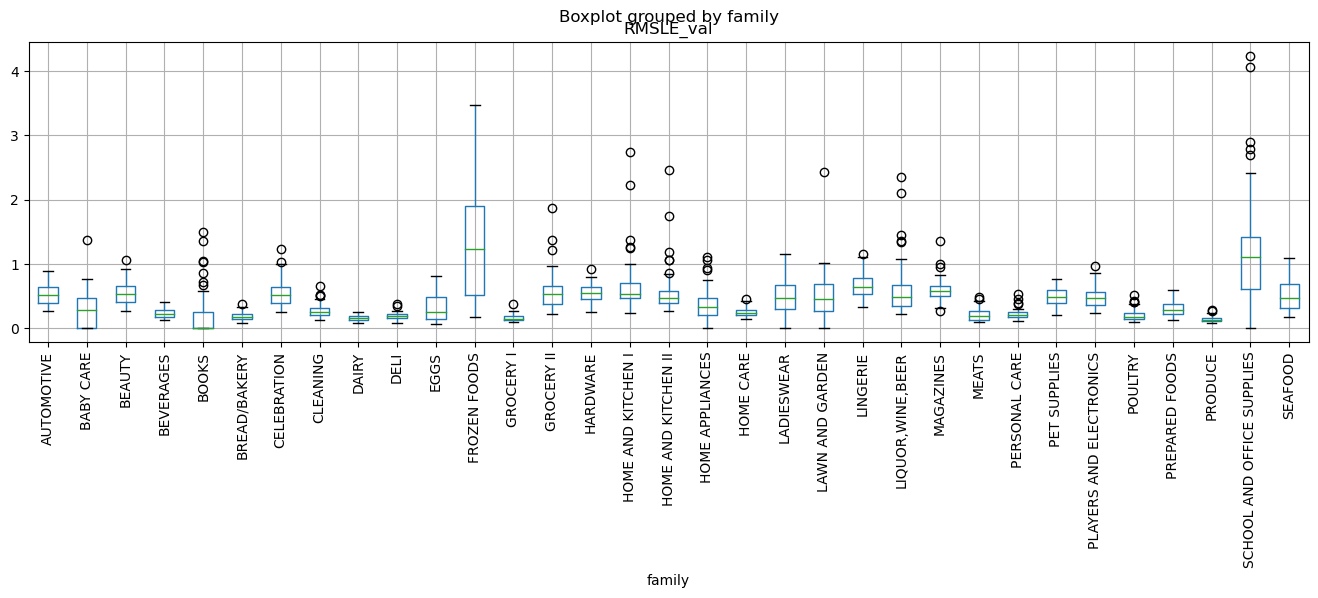

In [12]:
val_errors.boxplot(column='RMSLE_val', by='family')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: >

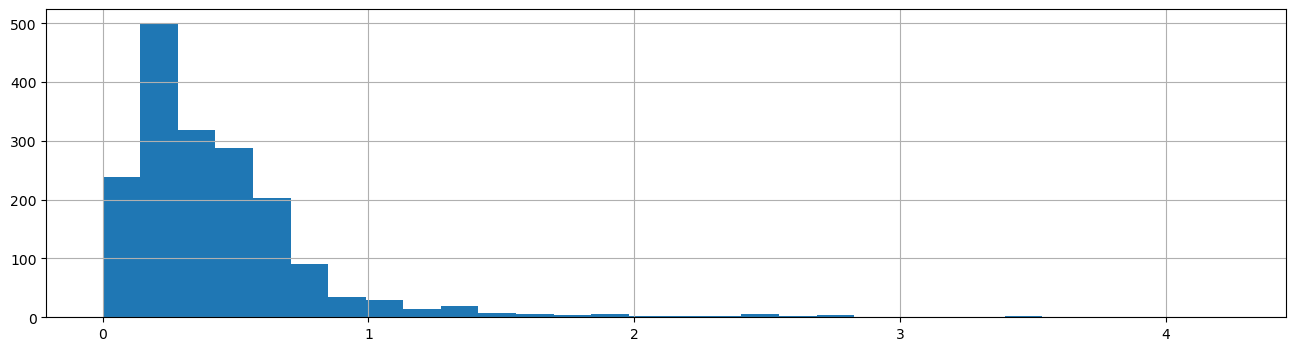

In [17]:
val_errors.RMSLE_val.hist(bins=30)

In [91]:
val_errors[val_errors.RMSLE_val>=1].sort_values('RMSLE_val', ascending=False).head(30)

,store_nbr,family,RMSLE_val
1549,47,SCHOOL AND OFFICE SUPPLIES,4.242
1648,50,SCHOOL AND OFFICE SUPPLIES,4.063
1562,48,FROZEN FOODS,3.479
1628,50,FROZEN FOODS,3.438
1496,46,FROZEN FOODS,3.170
1318,40,SCHOOL AND OFFICE SUPPLIES,2.900
295,9,SCHOOL AND OFFICE SUPPLIES,2.794
836,26,FROZEN FOODS,2.787
1599,49,HOME AND KITCHEN I,2.746
1054,32,SCHOOL AND OFFICE SUPPLIES,2.689


In [18]:
val_errors[val_errors.RMSLE_val>=1].family.value_counts()

FROZEN FOODS                  30
SCHOOL AND OFFICE SUPPLIES    29
LIQUOR,WINE,BEER               8
HOME AND KITCHEN II            5
LADIESWEAR                     5
HOME AND KITCHEN I             5
BOOKS                          4
SEAFOOD                        4
GROCERY II                     3
LINGERIE                       3
LAWN AND GARDEN                3
HOME APPLIANCES                2
MAGAZINES                      2
CELEBRATION                    2
BABY CARE                      1
BEAUTY                         1
Name: family, dtype: int64

In [19]:
val_errors[val_errors.RMSLE_val<1].family.value_counts()

AUTOMOTIVE                    54
DELI                          54
PERSONAL CARE                 54
HOME CARE                     54
PET SUPPLIES                  54
PLAYERS AND ELECTRONICS       54
HARDWARE                      54
POULTRY                       54
GROCERY I                     54
EGGS                          54
DAIRY                         54
CLEANING                      54
PREPARED FOODS                54
BREAD/BAKERY                  54
PRODUCE                       54
BEVERAGES                     54
MEATS                         54
BABY CARE                     53
BEAUTY                        53
MAGAZINES                     52
HOME APPLIANCES               52
CELEBRATION                   52
LINGERIE                      51
LAWN AND GARDEN               51
GROCERY II                    51
BOOKS                         50
SEAFOOD                       50
LADIESWEAR                    49
HOME AND KITCHEN II           49
HOME AND KITCHEN I            49
LIQUOR,WIN

## By store

In [5]:
store_nbr, family = 47, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 9, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 50, 'SCHOOL AND OFFICE SUPPLIES'
# store_nbr, family = 39, 'MEATS'
# store_nbr, family = 48, 'FROZEN FOODS'
# store_nbr, family = 25, 'FROZEN FOODS'
# store_nbr, family = 1, 'FROZEN FOODS'
# store_nbr, family = 49, 'HOME AND KITCHEN I'

storeFamily_daily = train[(train.store_nbr==store_nbr) & (train.family==family)]

print(f'Prophet training for Store {store_nbr}, {family}')

# storeFamily_daily = pd.merge(storeFamily_daily, stores, on='store_nbr')
city = stores[stores.store_nbr==store_nbr].city.values[0]
state = stores[stores.store_nbr==store_nbr].state.values[0]

relevant_holidays = parse_holidays(holidays, city, state)

model_pipeline = prophetPipeline(storeFamily_daily, oil_prophet, relevant_holidays, filter=True)

storeFamily_daily_test = test[(test.store_nbr==store_nbr) & (test.family==family)]

Prophet training for Store 47, SCHOOL AND OFFICE SUPPLIES


In [6]:
m = model_pipeline.trained_model
forecast = model_pipeline.forecast

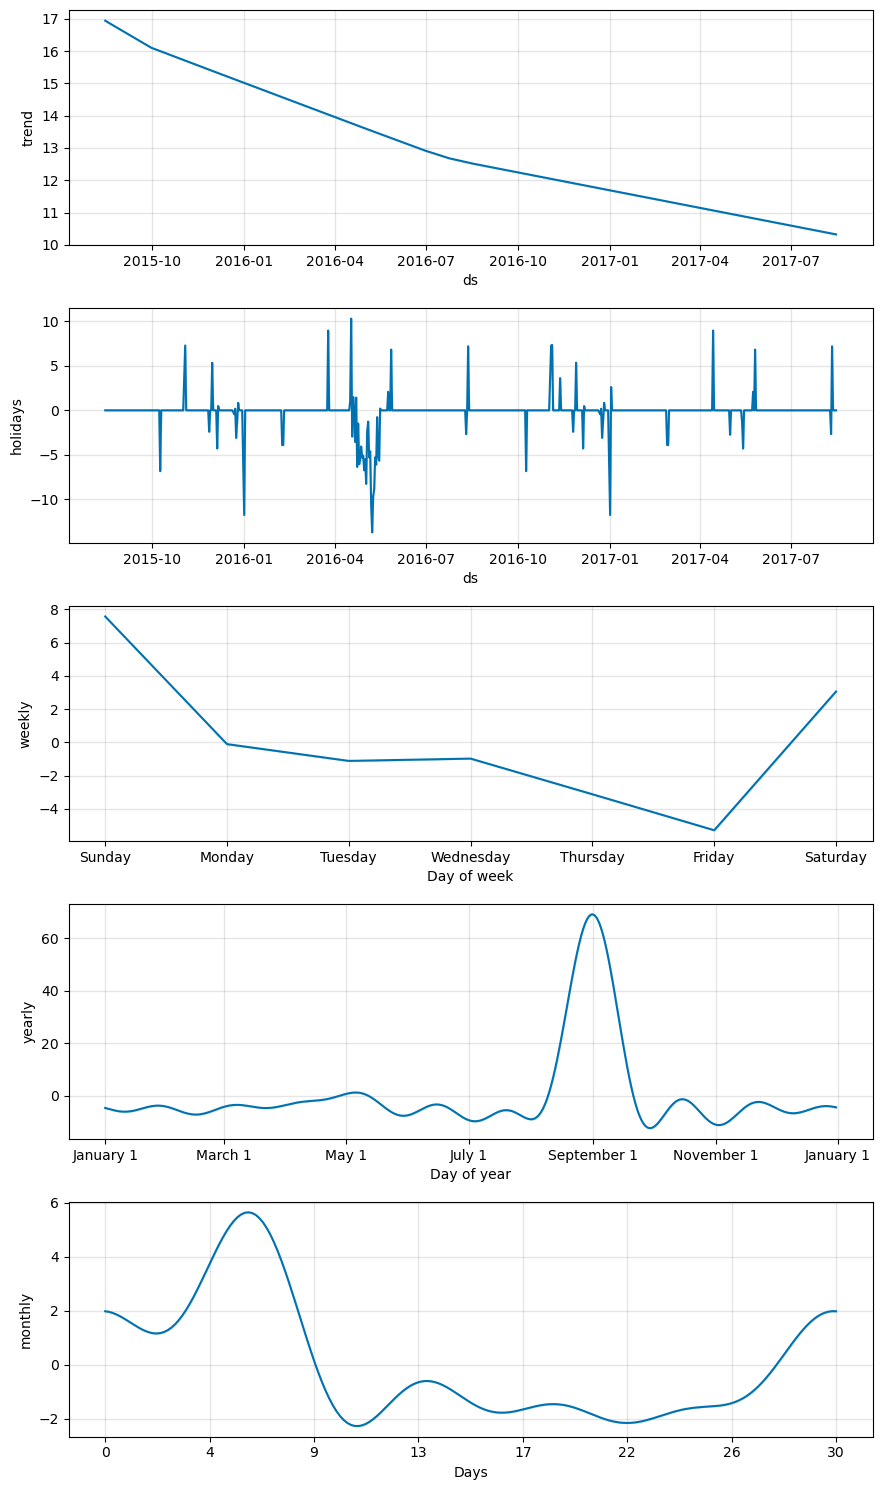

In [7]:
m.plot_components(forecast)
plt.show()

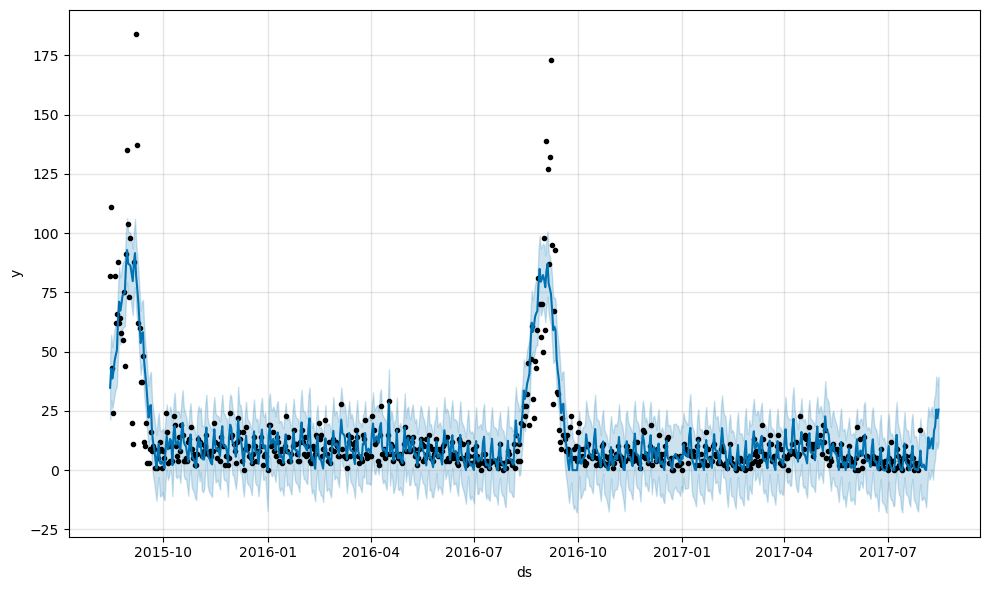

In [8]:
ax = m.plot(forecast)
plt.show()

<AxesSubplot: xlabel='date'>

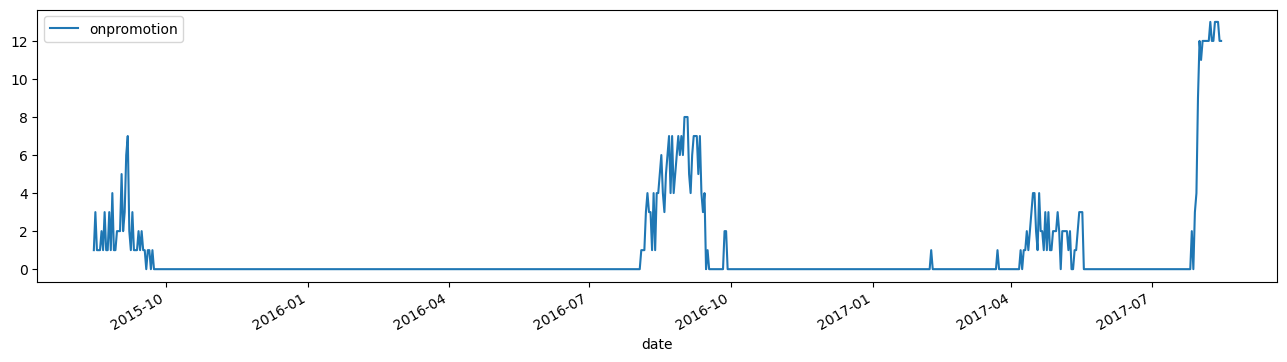

In [9]:
storeFamily_daily.set_index('date').plot(y='onpromotion')

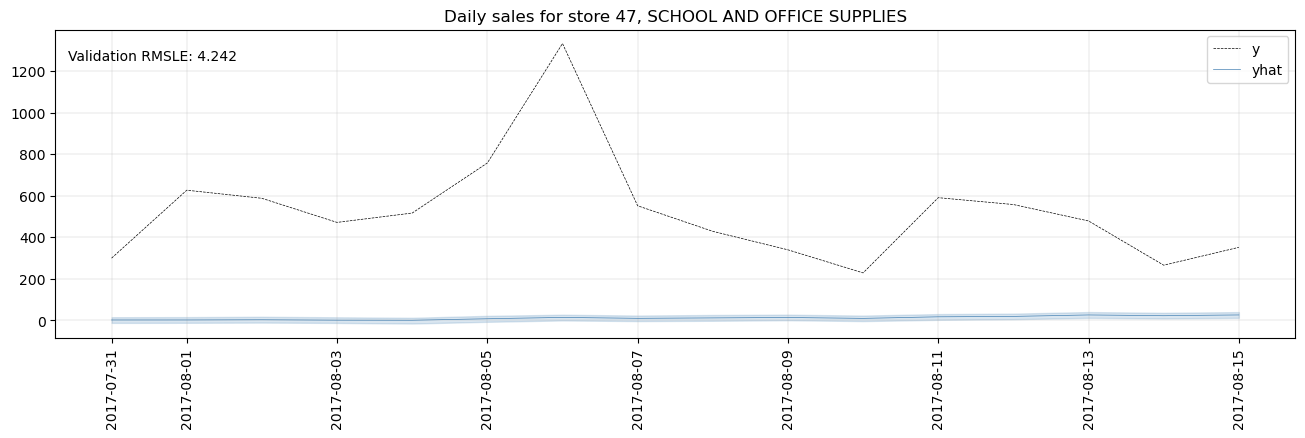

In [10]:
val_df = forecast[forecast.split=='validation']
# val_df = forecast[forecast.ds>='2016-07-01']
val_error = RMSLE(val_df.y, val_df.yhat)

ax = visualize_forecasts(val_df, title=f'Daily sales for store {store_nbr}, {family}')
# storeFamily_daily[storeFamily_daily.date.isin(val_df.ds)].set_index('date').plot(y='onpromotion', ax=ax)
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.text(0.01, 0.9, 'Validation RMSLE: %.03f' %val_error, transform=ax.transAxes)
plt.show()

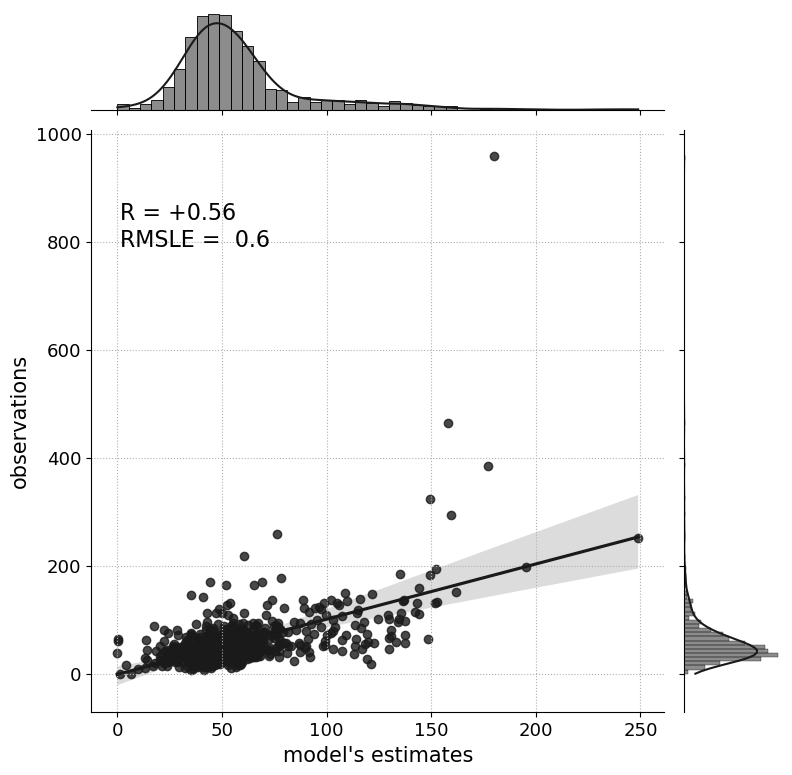

In [81]:
plot_joint_plot(forecast[forecast.split=='train'])

## By family

### Frozen Foods

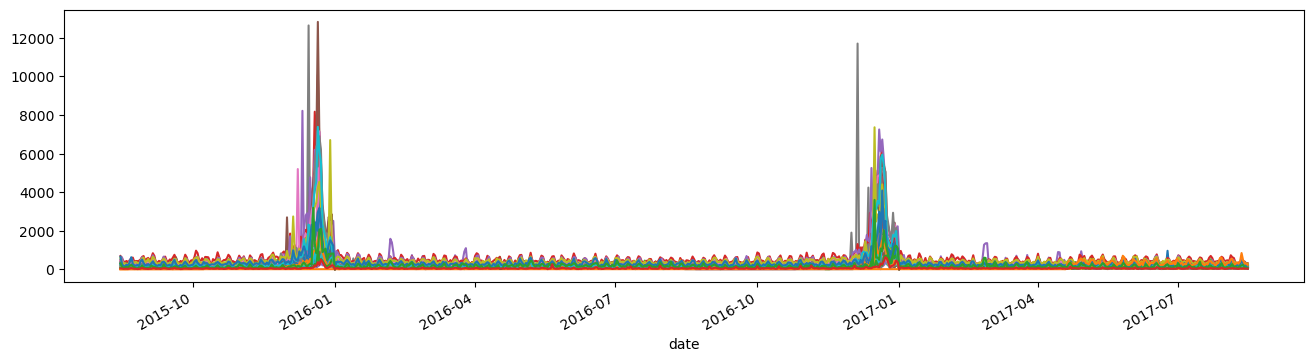

In [114]:
family = 'FROZEN FOODS'

family_daily = train[train.family==family]

# _family_daily = family_daily[family_daily.date>='2016-03-01'].set_index('date')
_family_daily = family_daily.set_index('date')

_family_daily.groupby('store_nbr').sales.plot()
plt.show()

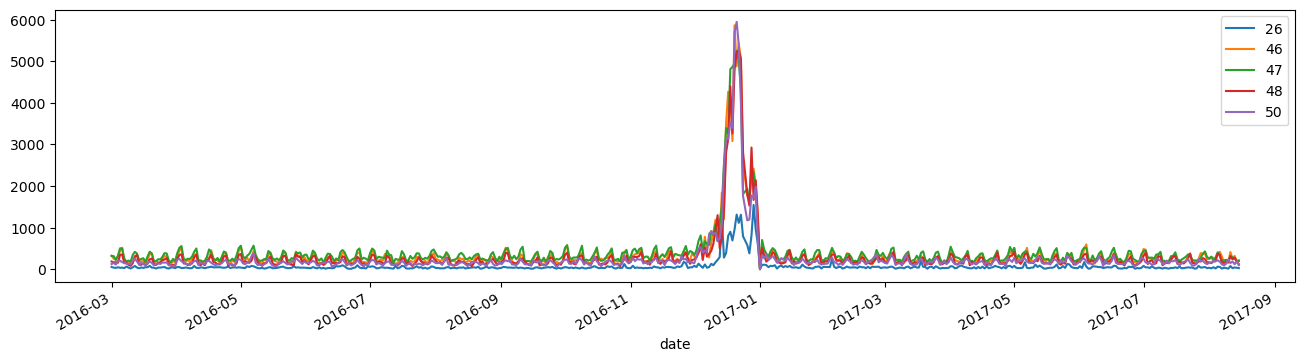

In [94]:
store_list = [48, 50, 46, 26, 47]
_family_daily[_family_daily.store_nbr.isin(store_list)].groupby('store_nbr').sales.plot()
plt.legend()
plt.show()

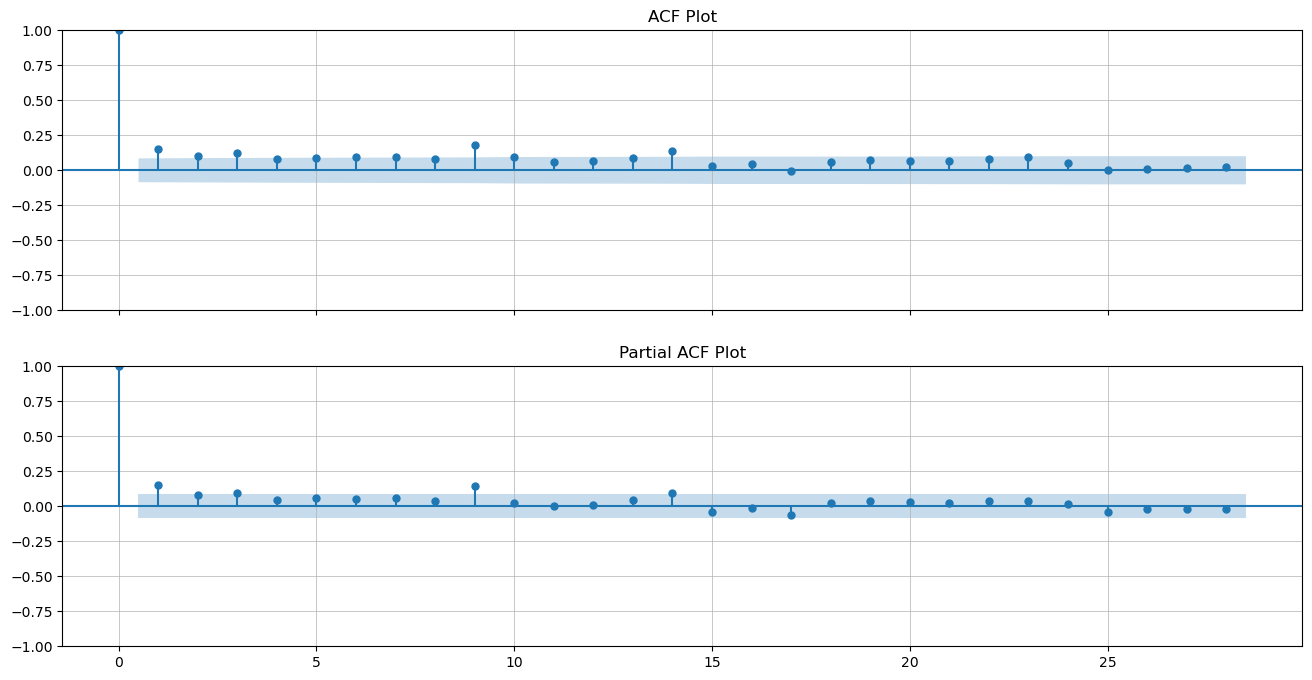

In [75]:
plot_autocorrelations(_family_daily[_family_daily.store_nbr==50].sales, lags=28)

### School and office supplies

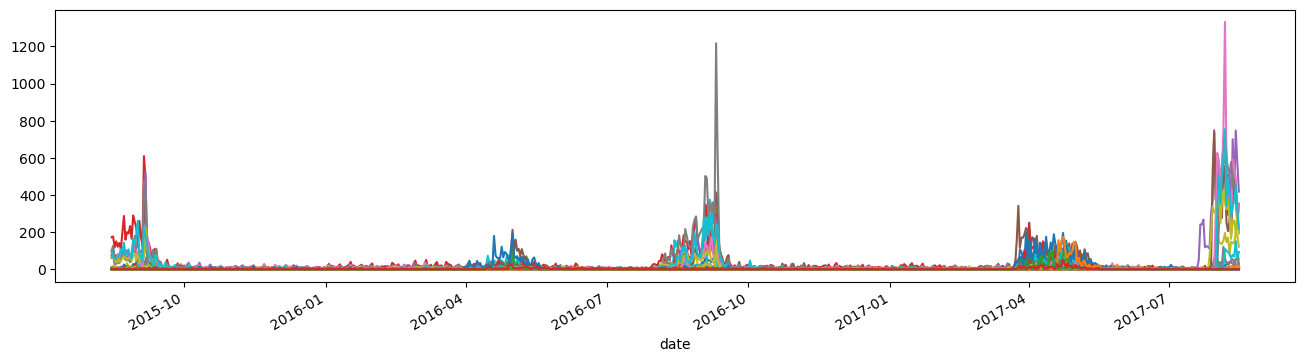

In [115]:
family = 'SCHOOL AND OFFICE SUPPLIES'

family_daily = train[train.family==family]

# _family_daily = family_daily[family_daily.date>='2016-03-01'].set_index('date')
_family_daily = family_daily.set_index('date')

_family_daily.groupby('store_nbr').sales.plot()
plt.show()

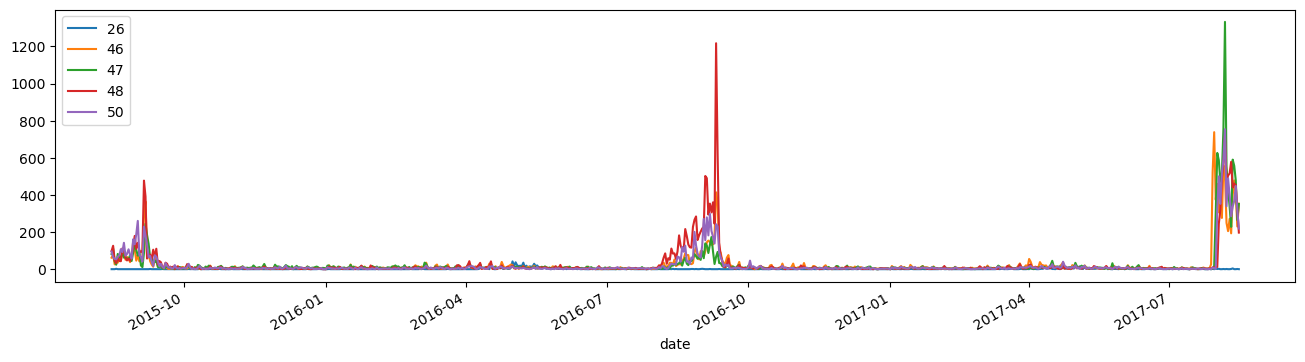

In [116]:
store_list = [48, 50, 46, 26, 47]
_family_daily[_family_daily.store_nbr.isin(store_list)].groupby('store_nbr').sales.plot()
plt.legend()
plt.show()

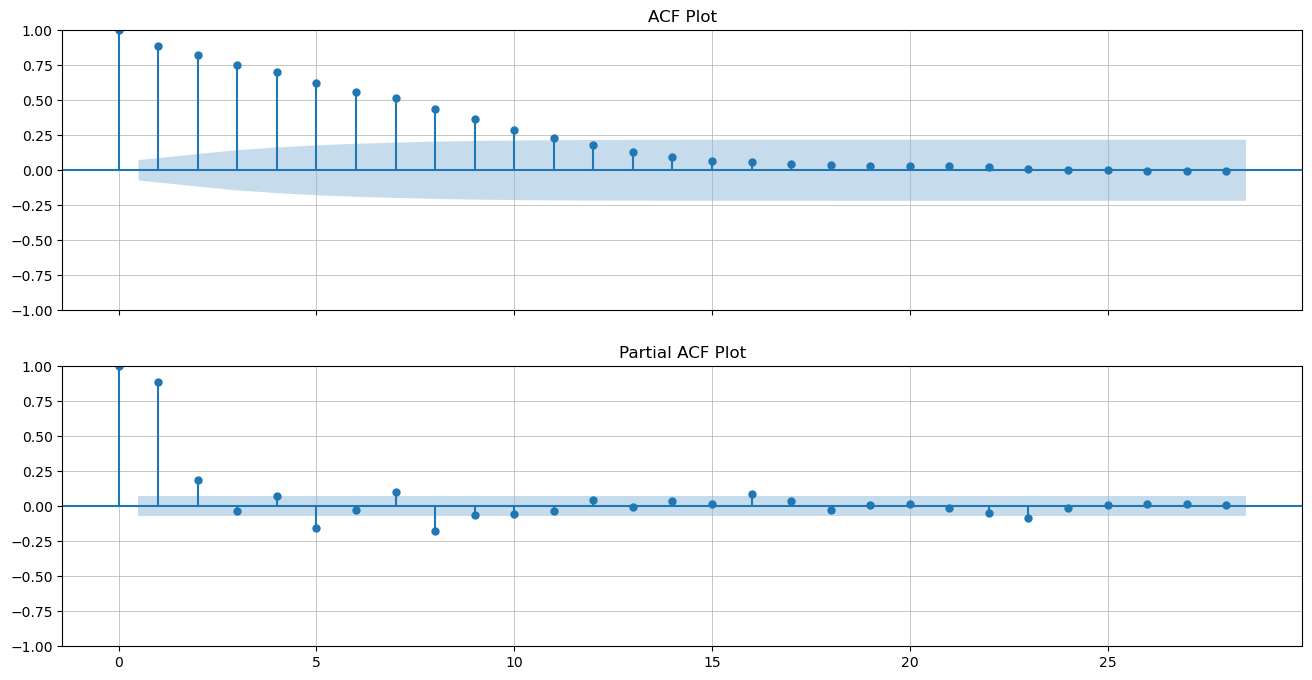

In [117]:
plot_autocorrelations(_family_daily[_family_daily.store_nbr==50].sales, lags=28)